# **Medical Q&A**
Our objective is to fine-tune a pre-trained language model to generate medically accurate answers, possibly including step-by-step reasoning. We treat this as a sequence-to-sequence task, where the model takes a patient question as input and produces a doctor-like response as output.


# To avoid importing duplicates

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
import re
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Importing** **Dataset**

In [ ]:
!pip install datasets

In [ ]:
!pip install transformers accelerate torch

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
!pip install -q gdown
import gdown

In [ ]:
import json

file_id = "1JzS6pOM6FktUbaar_qqkwaPHm48W2dyu"
output_name = "medical_dataset.json"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_name, quiet=False)

# Upload file JSON
with open(output_name, "r") as f:
    data = json.load(f)

# Convert the list of data into a Hugging Face Dataset object
train_dataset = Dataset.from_list(data)

# Create a DatasetDict to hold the dataset, initially just the training split
dataset = DatasetDict({
    "train": train_dataset})

# Shuffle the training dataset and select the first 1000 examples for use
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(1000))

# Print the structure of the dataset and the first example of the training split
print(dataset)
print(dataset["train"][0])

Downloading...
From: https://drive.google.com/uc?id=1JzS6pOM6FktUbaar_qqkwaPHm48W2dyu
To: /content/medical_dataset.json
100%|██████████| 58.2M/58.2M [00:00<00:00, 178MB/s]


DatasetDict({
    train: Dataset({
        features: ['Question', 'Complex_CoT', 'Response'],
        num_rows: 1000
    })
})
{'Question': 'In the instrument formula for a Gingival Margin Trimmer (GMT) used during cavity preparation, what is the second number representing the angle of the cutting edge when access to the distal gingival margin is achieved?', 'Complex_CoT': "Alright, so a Gingival Margin Trimmer, or GMT for short, is some sort of dental tool used during cavity prep. I need to figure out what that second number in its formula really means, especially when working with the distal gingival margin. Let's start with the basics about these numbers.\n\nThe first number in any dental instrument formula usually tells us the blade width, measured in tenths of a millimeter. Pretty straightforward.\n\nNow, the second number is where it gets interesting. It refers to the angle of the blade relative to the handle's long axis. So, it sort of dictates how the blade sits or tilts compar

# **Preprocessing**
We applied light, targeted preprocessing in order to preserve the integrity and precision of medical language


## **1. Case Folding**

In [ ]:
# Convert all string values in the dataset to lowercase
dataset = dataset.map(
    lambda x: {k: v.lower() if isinstance(v, str) else v for k, v in x.items()}
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
print(dataset["train"][0])

{'Question': 'in the instrument formula for a gingival margin trimmer (gmt) used during cavity preparation, what is the second number representing the angle of the cutting edge when access to the distal gingival margin is achieved?', 'Complex_CoT': "alright, so a gingival margin trimmer, or gmt for short, is some sort of dental tool used during cavity prep. i need to figure out what that second number in its formula really means, especially when working with the distal gingival margin. let's start with the basics about these numbers.\n\nthe first number in any dental instrument formula usually tells us the blade width, measured in tenths of a millimeter. pretty straightforward.\n\nnow, the second number is where it gets interesting. it refers to the angle of the blade relative to the handle's long axis. so, it sort of dictates how the blade sits or tilts compared to the main handle.\n\noh yeah, then there’s the third number, which gives us the idea about the angle of the cutting edge r

## **2. Removal**
**Stopwords**  

Stopword removal was deliberately avoided: although often used to reduce data dimensionality, stopwords in this context may carry semantic or syntactic importance (e.g., "no pain" vs. "pain"), and their removal could alter the intended medical meaning.

**Numbers**

Numbers were preserved without modification, as they frequently represent critical clinical information such as temperatures (e.g., "38.5°C"), dosages (e.g., "500mg"), durations ("2 days"), or measurements (e.g., "120/80"). Their removal would result in a substantial loss of factual context

**Punctuation**

We applied only basic text cleaning using regular expressions: this included removal of redundant whitespace, and malformed punctuation — but we explicitly retained clinically relevant punctuation, such as decimals, colons, and slashes.


In [ ]:
# Get the default string of punctuation characters
punc = string.punctuation
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Define punctuation to keep
punct_to_keep = {'.', '?', ':', '%'}

# Create a string of punctuation characters to remove
PUNCTUATIONS = ''.join([p for p in string.punctuation if p not in punct_to_keep])

# Function to remove specified punctuation from text
def remove_punctuation(text):
    # Create a translation table to replace specified punctuation with spaces
    trans = str.maketrans(dict.fromkeys(PUNCTUATIONS, ' '))
    # Apply the translation
    return text.translate(trans)

In [ ]:
# Apply punctuation removal to our columns in the dataset
dataset = dataset.map(
    lambda x: {
        **x,
        "Question": remove_punctuation(x["Question"]),
        "Response": remove_punctuation(x["Response"]),
        "Complex_CoT": remove_punctuation(x["Complex_CoT"]),})

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Function to remove multiple whitespaces from text
def remove_whitespaces(text):
    return " ".join(text.split())

In [ ]:
# Apply whitespace removal to relevant columns in the dataset
dataset = dataset.map(
    lambda x: {
        **x,
        "Question": remove_whitespaces(x["Question"]),
        "Response": remove_whitespaces(x["Response"]),
        "Complex_CoT": remove_whitespaces(x["Complex_CoT"]),})

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Print the first example after punctuation and whitespace removal
print(dataset["train"][0])

{'Question': 'in the instrument formula for a gingival margin trimmer gmt used during cavity preparation what is the second number representing the angle of the cutting edge when access to the distal gingival margin is achieved?', 'Complex_CoT': 'alright so a gingival margin trimmer or gmt for short is some sort of dental tool used during cavity prep. i need to figure out what that second number in its formula really means especially when working with the distal gingival margin. let s start with the basics about these numbers. the first number in any dental instrument formula usually tells us the blade width measured in tenths of a millimeter. pretty straightforward. now the second number is where it gets interesting. it refers to the angle of the blade relative to the handle s long axis. so it sort of dictates how the blade sits or tilts compared to the main handle. oh yeah then there’s the third number which gives us the idea about the angle of the cutting edge relative to the shank.

# **Visualization**



## 1. Word Cloud and Cosine Similarity

In [ ]:
from wordcloud import WordCloud

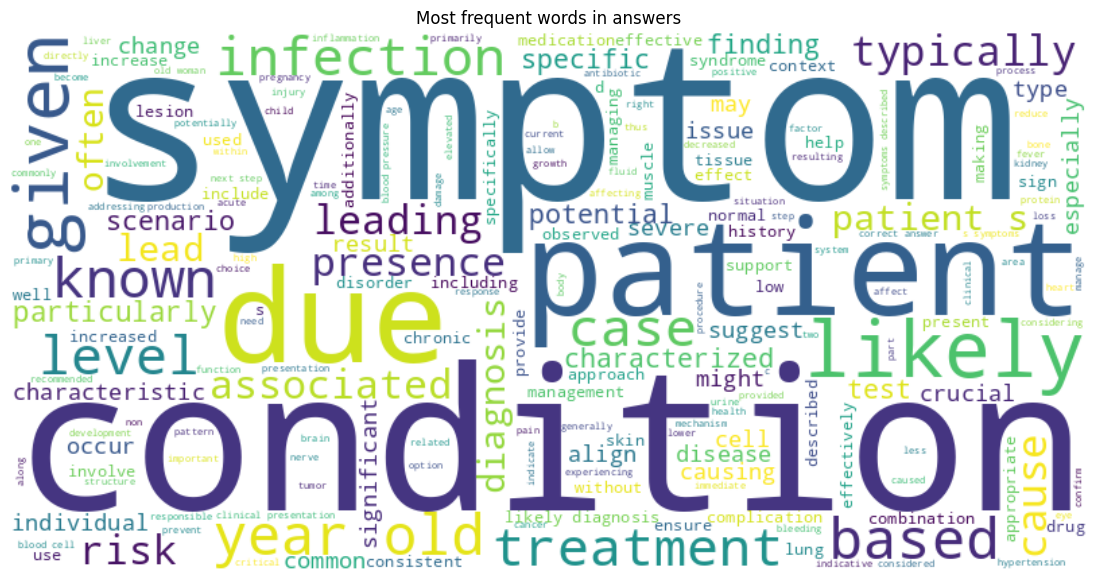

In [ ]:
# Access the 'Response' column from the 'train' split of the dataset
all_text = " ".join(dataset["train"]["Response"])
# Generate a word cloud from the text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the generated word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most frequent words in answers")
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


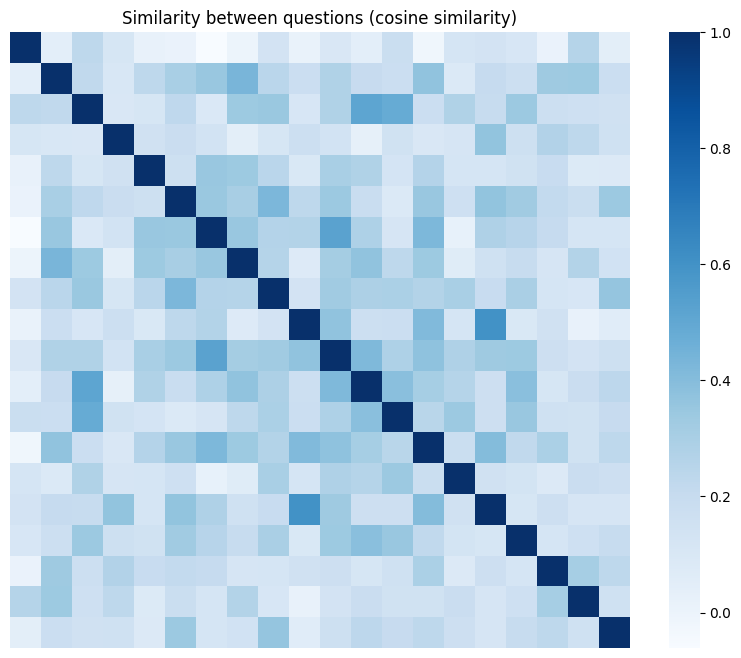

In [ ]:
# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Access the 'Question' column from the 'train' split
embeddings = model.encode(dataset["train"]["Question"][:20])

# Calculate the cosine similarity matrix between the question embeddings
sim_matrix = cosine_similarity(embeddings)

# Plot the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Similarity between questions (cosine similarity)")
plt.show()

##BERTopic
Using BERTopic with stopword filtering, we extracted five distinct semantic topics from the medical question dataset. These topics reflect recurring themes in clinical and anatomical reasoning:

Topic -1 – **Diagnosis and Clinical Terms**
Focused on diagnostic reasoning, diseases, symptoms, and medical testing terminology.

Topic 0 – **Neurology and Nerve Anatomy**
This cluster includes questions involving nerves, cranial functions, and neurological damage.

Topic 1 / 3 – **Physiology**
Covers questions exploring mechanisms, causes, and physiological responses related to disease.

Topic 2 – **Pharmacology and Treatments**
Contains queries about drugs, therapeutic interventions, dosage, and medication management.

Topic 4 – **Systemic Anatomy**
Involves anatomical structures, muscle localization, and organ-based questions.

In [ ]:
pip install bertopic sentence-transformers

In [ ]:
from bertopic import BERTopic

In [ ]:
# Access the 'Question' column from the 'train' split of the dataset
# Select a subset of documents (questions) for topic modeling
documents = dataset["train"]["Question"][:500]

# Load a pre-trained embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Create a BERTopic model with the specified embedding model
topic_model = BERTopic(embedding_model=embedding_model, language="english")

# Fit the BERTopic model to the documents and transform them to get topics and probabilities
topics, probs = topic_model.fit_transform(documents)

# Get information about the topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,199,-1_the_and_of_with,"[the, and, of, with, is, to, old, year, what, in]",[a 76 year old woman is experiencing increasin...
1,0,55,0_of_and_the_he,"[of, and, the, he, is, with, year, to, old, on]",[a 70 year old man three days post cardiac cat...
2,1,34,1_the_with_organism_in,"[the, with, organism, in, of, and, an, culture...",[a 22 year old woman presents with symptoms in...
3,2,34,2_the_his_and_with,"[the, his, and, with, is, of, on, in, lesions,...",[a 4 year old boy presents with developmental ...
4,3,25,3_is_the_of_and,"[is, the, of, and, history, abdominal, in, pai...",[a 26 year old woman with a history of asthma ...
5,4,24,4_the_is_pregnancy_weeks,"[the, is, pregnancy, weeks, at, of, and, what,...",[a male neonate whose mother experienced a mil...
6,5,21,5_kidney_with_and_urine,"[kidney, with, and, urine, renal, of, the, wha...",[in a case involving an 8 year old male with n...
7,6,20,6_the_hernia_which_to,"[the, hernia, which, to, in, of, forceps, spin...",[a known case of pulmonary tb presented to eme...
8,7,17,7_deficiency_of_and_anemia,"[deficiency, of, and, anemia, count, cells, at...",[considering the medical history and laborator...
9,8,17,8_the_she_ability_of,"[the, she, ability, of, to, what, his, and, is...",[a 30 year old man showed hyperthymia insomnia...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Get the list of English stop words from NLTK
stop_words = stopwords.words("english")

# Create a CountVectorizer with the stop words removed
vectorizer_model = CountVectorizer(stop_words=stop_words)

# Create a BERTopic model using the CountVectorizer (for explicit stop word removal)
topic_model = BERTopic(vectorizer_model=vectorizer_model)

# Select a subset of documents for topic modeling with stop word removal
documents = dataset["train"]["Question"][:200]

# Fit the BERTopic model and transform the documents
topics, probs = topic_model.fit_transform(documents)

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,98,-1_old_year_presents_symptoms,"[old, year, presents, symptoms, patient, likel...",[a 39 year old man reports chronic fatigue and...
1,0,26,0_nerve_right_patient_old,"[nerve, right, patient, old, side, management,...",[a 27 year old woman develops hyperacusis due ...
2,1,20,1_organism_positive_cell_infection,"[organism, positive, cell, infection, chains, ...",[a pregnant lady with aids complaint of diarrh...
3,2,15,2_serum_pain_abdominal_year,"[serum, pain, abdominal, year, history, findin...",[a 26 year old woman with a history of asthma ...
4,3,15,3_clinical_thyroid_lesions_node,"[clinical, thyroid, lesions, node, cervical, p...",[a 35 year old female presents with a swelling...
5,4,14,4_removal_weeks_rh_stimulation,"[removal, weeks, rh, stimulation, hormone, glo...",[a 33 year old g1p0 at 39 weeks gestation is a...
6,5,12,5_chest_lung_likely_year,"[chest, lung, likely, year, dyspnea, ecg, old,...",[a 51 year old man experiences progressively w...


In [ ]:
# Get and print information about the topics
topic_model.get_topic(-1)

[('old', np.float64(0.04125543566918613)),
 ('year', np.float64(0.039222145257697606)),
 ('presents', np.float64(0.027138377557951628)),
 ('symptoms', np.float64(0.025886615870080416)),
 ('patient', np.float64(0.02451843955443908)),
 ('likely', np.float64(0.024496783495179125)),
 ('condition', np.float64(0.02038092970832779)),
 ('woman', np.float64(0.02038092970832779)),
 ('normal', np.float64(0.020003294081425774)),
 ('examination', np.float64(0.019805205089721806))]

In [ ]:
topic_model.get_topic(0)

[('nerve', np.float64(0.05776569638255733)),
 ('right', np.float64(0.04045702595436342)),
 ('patient', np.float64(0.037890289209370404)),
 ('old', np.float64(0.037591566463692376)),
 ('side', np.float64(0.037405790389685216)),
 ('management', np.float64(0.037405790389685216)),
 ('trauma', np.float64(0.03684368449630904)),
 ('spinal', np.float64(0.03684368449630904)),
 ('paralysis', np.float64(0.03684368449630904)),
 ('margin', np.float64(0.03684368449630904))]

In [ ]:
topic_model.get_topic(1)

[('organism', np.float64(0.07237869259180868)),
 ('positive', np.float64(0.05762357847928349)),
 ('cell', np.float64(0.035420993348599876)),
 ('infection', np.float64(0.034720374243330264)),
 ('chains', np.float64(0.03446215981336375)),
 ('antibiotic', np.float64(0.03446215981336375)),
 ('infected', np.float64(0.03446215981336375)),
 ('virus', np.float64(0.03446215981336375)),
 ('rate', np.float64(0.0334813226938038)),
 ('culture', np.float64(0.032708168889580475))]

In [ ]:
topic_model.get_topic(2)

[('serum', np.float64(0.051067899053779814)),
 ('pain', np.float64(0.049385700020713)),
 ('abdominal', np.float64(0.04902905858986988)),
 ('year', np.float64(0.04344794361964276)),
 ('history', np.float64(0.04224825504262896)),
 ('findings', np.float64(0.04151977049320423)),
 ('old', np.float64(0.0369544212693925)),
 ('laboratory', np.float64(0.03604445631193184)),
 ('min', np.float64(0.03537616330420031)),
 ('likely', np.float64(0.03354733893578719))]

In [ ]:
topic_model.get_topic(3)

[('clinical', np.float64(0.09305371672387786)),
 ('thyroid', np.float64(0.08725027057782098)),
 ('lesions', np.float64(0.0869664014561591)),
 ('node', np.float64(0.07717591611334419)),
 ('cervical', np.float64(0.07089636066619888)),
 ('presents', np.float64(0.07069809853034088)),
 ('diagnosis', np.float64(0.07064163905085952)),
 ('normal', np.float64(0.06866326804175685)),
 ('lymph', np.float64(0.062321621841300696)),
 ('based', np.float64(0.05522753271452467))]

In [ ]:
topic_model.get_topic(4)

[('removal', np.float64(0.07014227613774486)),
 ('weeks', np.float64(0.0621557134607771)),
 ('rh', np.float64(0.05854612878865546)),
 ('stimulation', np.float64(0.05854612878865546)),
 ('hormone', np.float64(0.05611382091019589)),
 ('globulin', np.float64(0.04626426933848832)),
 ('mice', np.float64(0.04626426933848832)),
 ('infertility', np.float64(0.04626426933848832)),
 ('hypothalamus', np.float64(0.04626426933848832)),
 ('woman', np.float64(0.046000793000021065))]

# **Train, Test and Validation Sets**

In [ ]:
# Original Dataset
dataset = dataset["train"]

# Split the dataset into a training set (60%) and a temporary set (40%)
split = dataset.train_test_split(test_size=0.4, seed=42)
train_dataset = split["train"]
temp_dataset = split["test"]

# Split the temporary set into a validation set (50% of temp, so 20% of original) and a test set (50% of temp, so 20% of original)
split_temp = temp_dataset.train_test_split(test_size=0.5, seed=42)
val_dataset = split_temp["train"]
test_dataset = split_temp["test"]

# Print the size of each resulting dataset split
print("Training set:", len(train_dataset))
print("Validation set:", len(val_dataset))
print("Test set:", len(test_dataset))

Training set: 600
Validation set: 200
Test set: 200


In [ ]:
pip install tensorflow

In [ ]:
print(dataset)

Dataset({
    features: ['Question', 'Complex_CoT', 'Response'],
    num_rows: 1000
})


In [ ]:
# Print the structure of the train, validation, and test datasets
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['Question', 'Complex_CoT', 'Response'],
    num_rows: 600
})
Dataset({
    features: ['Question', 'Complex_CoT', 'Response'],
    num_rows: 200
})
Dataset({
    features: ['Question', 'Complex_CoT', 'Response'],
    num_rows: 200
})


In [ ]:
!pip install --upgrade transformers

In [ ]:
import transformers
print(transformers.__version__)

4.52.4


# To avoid copies

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM
import torch
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer

# **T5-Small Model**
A baseline encoder-decoder model pretrained on general-domain tasks. T5 uses a unified text-to-text framework but lacks specialization for biomedical content.

## **Importing Model**

In [ ]:
model_name_t5 = "t5-small"
print(model_name_t5)


# Load the pre-trained T5-small model for sequence-to-sequence tasks
model_t5 = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
# Print the loaded model object to see its architecture
model_t5

##**Tokenization**

In [ ]:
# Load the tokenizer for the T5-small model
tokenizer_t5 = AutoTokenizer.from_pretrained("t5-small")

# Define a function to preprocess the dataset for the T5 model
def preprocess_function_t5(examples):
  question = examples.get("Question", "")
  cot = examples.get("Complex_CoT", "")
  response = examples.get("Response", "")

# Combine Question and Complex_CoT as the input sequence
  full_input = question + " " + cot

# Tokenize the input sequence
  model_inputs = tokenizer_t5(
      full_input,
      max_length=128,
      truncation=True,
      padding="max_length"
  )

# Tokenize the target sequence ('Response') within the target tokenizer context
  with tokenizer_t5.as_target_tokenizer():
      labels = tokenizer_t5(
          response,
          max_length=128,
          truncation=True,
          padding="max_length"
      )

# Replace padding token IDs in labels with -100 so they are ignored in loss calculation
  labels["input_ids"] = [
      (label if label != tokenizer_t5.pad_token_id else -100)
      for label in labels["input_ids"]
  ]

# Add the processed labels to the model inputs
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

# Apply the preprocessing function to the train, validation, and test datasets
tokenized_train_dataset_t5 = train_dataset.map(preprocess_function_t5)
tokenized_val_dataset_t5 = val_dataset.map(preprocess_function_t5)
tokenized_test_dataset_t5 = test_dataset.map(preprocess_function_t5)

In [ ]:
import tensorflow as tf

In [ ]:
!pip install tf_keras

## **Training**

In [ ]:
model_name_output_dir_t5 = model_name_t5.replace("/", "-")+"-finetuned-dataset"

# Define training parameters
batch_size = 16
epochs_t5 = 5

# Calculate logging steps based on dataset size and batch size
logging_steps = (len(tokenized_test_dataset_t5) + len(tokenized_train_dataset_t5) + len(tokenized_val_dataset_t5)) // batch_size

# Get the length of the training dataset
train_data_len_t5 = len(tokenized_train_dataset_t5)
# Calculate the total number of training steps
total_steps_t5 = (train_data_len_t5 // batch_size) * epochs_t5

In [ ]:
# Define training arguments using TrainingArguments class
training_args_t5 = TrainingArguments(
    output_dir=model_name_output_dir_t5, # Directory to save outputs
    num_train_epochs=epochs_t5, # Number of training epochs
    learning_rate=3e-5, # Learning rate
    per_device_train_batch_size=batch_size, # Batch size per device for training
    per_device_eval_batch_size=batch_size, # Batch size per device for evaluation
    weight_decay=0.01, # Weight decay for regularization
    metric_for_best_model="rougeL", # Metric to monitor for best model selection
    lr_scheduler_type="linear", # Learning rate scheduler type
    warmup_steps=int(0.1 * total_steps_t5), # Number of warm-up steps
    logging_steps=10, # Log training information every 10 steps
    log_level="error", # Set logging level to error
    optim='adamw_torch', # Optimizer to use
    report_to="none", # Do not report training progress to external services
    eval_strategy="epoch", # Evaluate at the end of each epoch
    save_strategy="epoch", # Save checkpoint at the end of each epoch
    load_best_model_at_end=True, # Load the best model based on metric_for_best_model at the end of training
)

## **Defining the Metrics**

In [ ]:
!pip install rouge-score

In [ ]:
!pip install evaluate

In [ ]:
from rouge_score import rouge_scorer
import evaluate

In [ ]:
# Load the ROUGE evaluation metric
rouge = evaluate.load("rouge")

# Define a function to compute metrics during evaluation
def compute_metrics_t5(eval_preds):
    predictions, labels = eval_preds

    if isinstance(predictions, tuple):
        predictions = predictions[0]

    if predictions.ndim == 3:
        predictions = np.argmax(predictions, axis=-1)

    labels = np.where(labels != -100, labels, tokenizer_t5.pad_token_id)

# Decode the predicted and reference token IDs back to strings
    decoded_preds = tokenizer_t5.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer_t5.batch_decode(labels, skip_special_tokens=True)

# Remove leading/trailing whitespace from decoded strings
    decoded_preds = [p.strip() for p in decoded_preds]
    decoded_labels = [l.strip() for l in decoded_labels]

# Compute ROUGE scores between predictions and references
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

# Process the ROUGE results
    processed_results = {}
    for k, v in result.items():
        if hasattr(v, 'mid'):
            processed_results[k] = v.mid.fmeasure
        else:
            print(f"Warning: Metric '{k}' did not return a Score object. Returning value directly.")
            processed_results[k] = float(v)

    print("Done", processed_results)

    print("Done", result)
    return result

## **Evaluation and Prediction**

In [ ]:
import numpy as np

In [ ]:
# Initialize the Trainer for the T5 model
trainer_t5 = Trainer(model=model_t5,
                  args=training_args_t5, # Training arguments
                  compute_metrics=compute_metrics_t5, # Function to compute metrics
                  train_dataset=tokenized_train_dataset_t5, # Training dataset
                  eval_dataset=tokenized_val_dataset_t5, # Validation dataset
                  tokenizer=tokenizer_t5 # Tokenizer
                  )

trainer_t5.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,3.229800,3.031920,0.474363,0.191827,0.392906,0.392971
2,3.119300,2.996655,0.469236,0.190673,0.389030,0.389209
3,3.179600,2.976806,0.465307,0.189829,0.386022,0.386192
4,3.153500,2.964923,0.462708,0.190085,0.385175,0.385399
5,3.196500,2.961801,0.462008,0.189777,0.384889,0.385244


Done {'rouge1': 0.47436331837778867, 'rouge2': 0.19182747175605364, 'rougeL': 0.39290612906599776, 'rougeLsum': 0.3929711829263093}
Done {'rouge1': np.float64(0.47436331837778867), 'rouge2': np.float64(0.19182747175605364), 'rougeL': np.float64(0.39290612906599776), 'rougeLsum': np.float64(0.3929711829263093)}
Done {'rouge1': 0.46923587628333385, 'rouge2': 0.19067286952224877, 'rougeL': 0.3890301318604059, 'rougeLsum': 0.38920856969425266}
Done {'rouge1': np.float64(0.46923587628333385), 'rouge2': np.float64(0.19067286952224877), 'rougeL': np.float64(0.3890301318604059), 'rougeLsum': np.float64(0.38920856969425266)}
Done {'rouge1': 0.46530685387809445, 'rouge2': 0.1898293179816344, 'rougeL': 0.38602241453307073, 'rougeLsum': 0.3861919950568202}
Done {'rouge1': np.float64(0.46530685387809445), 'rouge2': np.float64(0.1898293179816344), 'rougeL': np.float64(0.38602241453307073), 'rougeLsum': np.float64(0.3861919950568202)}
Done {'rouge1': 0.4627081910393771, 'rouge2': 0.1900853152357778, 

TrainOutput(global_step=190, training_loss=3.1779659170853463, metrics={'train_runtime': 156.7146, 'train_samples_per_second': 19.143, 'train_steps_per_second': 1.212, 'total_flos': 101506351104000.0, 'train_loss': 3.1779659170853463, 'epoch': 5.0})

In [ ]:
trainer_t5.save_model()

In [ ]:
# Evaluate the trained model on the validation dataset
trainer_t5.evaluate()

Done {'rouge1': 0.47436331837778867, 'rouge2': 0.19182747175605364, 'rougeL': 0.39290612906599776, 'rougeLsum': 0.3929711829263093}
Done {'rouge1': np.float64(0.47436331837778867), 'rouge2': np.float64(0.19182747175605364), 'rougeL': np.float64(0.39290612906599776), 'rougeLsum': np.float64(0.3929711829263093)}


{'eval_loss': 3.0319201946258545,
 'eval_rouge1': 0.47436331837778867,
 'eval_rouge2': 0.19182747175605364,
 'eval_rougeL': 0.39290612906599776,
 'eval_rougeLsum': 0.3929711829263093,
 'eval_runtime': 9.2007,
 'eval_samples_per_second': 21.738,
 'eval_steps_per_second': 1.413,
 'epoch': 5.0}

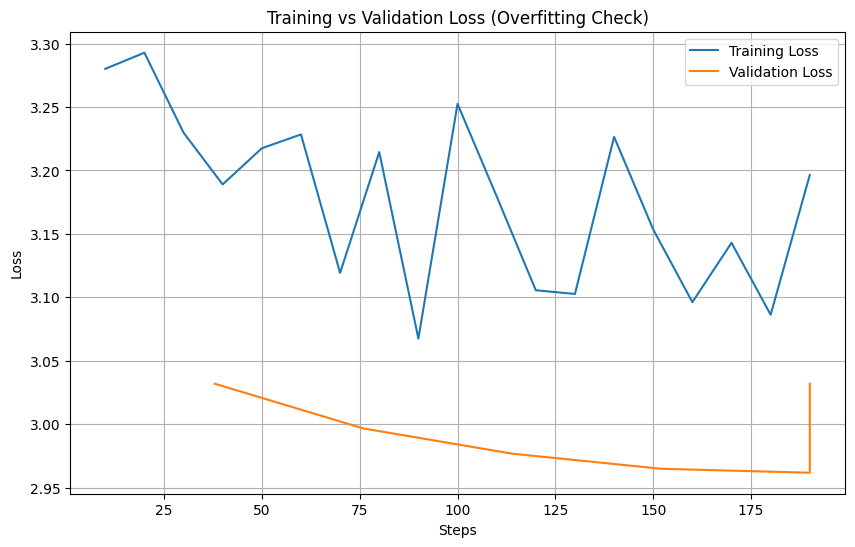

In [ ]:
# Get the training logs from the trainer state
logs_t5 = trainer_t5.state.log_history

# Initialize lists to store training loss, evaluation loss, and steps
train_loss_t5 = []
eval_loss_t5 = []
steps_t5 = []

# Iterate through the log history
for entry in logs_t5:

    # If the entry contains 'loss' but not 'eval_loss', it's a training loss
    if "loss" in entry:
        train_loss_t5.append(entry["loss"])
        steps_t5.append(entry["step"]) # Store the step number for training loss

    # If the entry contains 'eval_loss', it's a validation loss
    elif "eval_loss" in entry:
        eval_loss_t5.append(entry["eval_loss"])

# Extract steps corresponding to training and evaluation losses
train_steps_t5 = steps_t5[:len(train_loss_t5)]
eval_steps_t5 = [entry["step"] for entry in logs_t5 if "eval_loss" in entry] # Correctly extract steps for eval loss

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_steps_t5, train_loss_t5, label="Training Loss")
plt.plot(eval_steps_t5, eval_loss_t5, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Overfitting Check)")
plt.legend()
plt.grid(True)
plt.show()

## **Simulation**

In [ ]:
# Select a sample of 100 examples from the tokenized validation dataset for simulation
sample_eval_t5 = tokenized_val_dataset_t5.select(range(100))

# Generate predictions for the sample evaluation dataset using the trained model
predictions_output_t5 = trainer_t5.predict(sample_eval_t5)

preds_t5 = predictions_output_t5.predictions
labels_t5 = predictions_output_t5.label_ids

if isinstance(preds_t5, tuple):
    preds_t5 = preds_t5[0]

if preds_t5.ndim == 3:
    preds_t5 = np.argmax(preds_t5, axis=-1)

labels_t5 = np.where(labels_t5 == -100, tokenizer_t5.pad_token_id, labels_t5)

decoded_preds_t5 = tokenizer_t5.batch_decode(preds_t5, skip_special_tokens=True)
decoded_labels_t5 = tokenizer_t5.batch_decode(labels_t5, skip_special_tokens=True)

decoded_preds_t5 = [p.strip() for p in decoded_preds_t5]
decoded_labels_t5 = [l.strip() for l in decoded_labels_t5]

# Print the predictions and references for each example in the sample
for i in range(len(decoded_preds_t5)):
    print(f"\n Example {i+1}")
    print(f" Prediction: {decoded_preds_t5[i]}")
    print(f" Reference: {decoded_labels_t5[i]}")

Done {'rouge1': 0.48230451731973656, 'rouge2': 0.20307184148516527, 'rougeL': 0.40427286911353855, 'rougeLsum': 0.4034548786793657}
Done {'rouge1': np.float64(0.48230451731973656), 'rouge2': np.float64(0.20307184148516527), 'rougeL': np.float64(0.40427286911353855), 'rougeLsum': np.float64(0.4034548786793657)}

 Example 1
 Prediction: the  significance of hera 60 year old woman with  hypochromic microcytic anemia hemo a history of 8 blood transfusions in  common factor are determine the be be  hemoousus and the theic of globin oflyesis. determine the thedeterminingawingo. with  a the theemia. . thea anglobris is a  condition that causes  oxidehydr of the intestin and   a cause cause of ancytic anemia. the  of    which  of the the thea
 Reference: given the clinical context of a 60 year old woman with persistent hypochromic microcytic anemia and a history of multiple blood transfusions the most relevant investigations to consider would typically include serum ferritin to assess iron lev

In [ ]:
# Define a function to generate an answer using the fine-tuned T5 model
def answer_question_t5(question, cot=""):
# Combine the question and optional chain of thought for the model input
    full_input = question.strip().lower() + " " + cot.strip().lower()

    # Tokenize the input and prepare it as a PyTorch tensor
    input_ids = tokenizer_t5(full_input, return_tensors="pt", max_length=128, truncation=True, padding="max_length").input_ids

    device = next(model_t5.parameters()).device
    input_ids = input_ids.to(device)

    # Generate output token IDs using the model
    output_ids = model_t5.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)

    # Decode the generated token IDs back to a string, skipping special tokens
    response = tokenizer_t5.decode(output_ids[0], skip_special_tokens=True)

    return response

In [ ]:
# Move the T5 model to the GPU if available
model_t5 = model_t5.to("cuda")

In [ ]:
# Start an interactive loop for asking questions
while True:
    domanda = input("Insert your medical question (or digit 'exit'): ")
    # If the user types 'exit', break the loop
    if domanda.lower() == 'exit':
        break
    cot = input("Give (optionally) a chain of thought: ")
    risposta = answer_question_t5(domanda, cot)
    print("\n Model's answer:", risposta)
    print("-" * 50)

Insert your medical question (or digit 'exit'): what are diabetes symptoms?
Give (optionally) a chain of thought: 

 Model's answer: Welche Diabetes symptoms are diabetes symptoms?
--------------------------------------------------
Insert your medical question (or digit 'exit'): An 8-year-old boy presents with 6 months of progressive fatigue, weight loss, decreased energy, loose stools, occasional abdominal pain and nausea, tanned skin, and bluish-black gums. Serum studies indicate hyponatremia, hyperkalemia, and hypoglycemia. Based on these symptoms and laboratory findings, what is the initial step in treatment that should be administered to this patient?
Give (optionally) a chain of thought: 

 Model's answer: serum studies indicate hyponatremia, hyperkalemia, and hypoglycemia. based on these symptoms and laboratory findings, what is initial step in treatment that should be administered to this patient?
--------------------------------------------------
Insert your medical question (

# **SciFive Model**
A domain-adapted version of T5 pretrained on biomedical corpora such as PubMed and PMC. SciFive is better suited for medical question answering and terminology-rich tasks.

## **Importing Model**

In [ ]:
model_name_scifive = "razent/SciFive-base-Pubmed"
# Load the tokenizer for the SciFive model
tokenizer_scifive = AutoTokenizer.from_pretrained(model_name_scifive)
# Load the pre-trained SciFive model for sequence-to-sequence tasks
model_scifive = AutoModelForSeq2SeqLM.from_pretrained(model_name_scifive)

config.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
# Print the loaded SciFive model object to see its architecture
model_scifive

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

## **Tokenization**

In [ ]:
# Define a function to preprocess the dataset for the SciFive model
def preprocess_function_scifive(examples):

# Combine Question and Complex_CoT as the input sequence
    full_input_scifive = examples["Question"] + " " + examples["Complex_CoT"]

    # Input tokenization
    model_inputs_scifive = tokenizer_scifive(
        full_input_scifive,
        max_length=128,
        truncation=True,
        padding="max_length"
    )

    #Target tokenization
    with tokenizer_scifive.as_target_tokenizer():
        labels_scifive = tokenizer_scifive(
            examples["Response"],
            max_length=128,
            truncation=True,
            padding="max_length"
        )

    model_inputs_scifive["labels"] = labels_scifive["input_ids"]

    return model_inputs_scifive

# Apply the preprocessing function to the train, validation, and test datasets
tokenized_train_dataset_scifive = train_dataset.map(preprocess_function_scifive)
tokenized_val_dataset_scifive = val_dataset.map(preprocess_function_scifive)
tokenized_test_dataset_scifive = test_dataset.map(preprocess_function_scifive)

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

## **Training**

In [ ]:
# Define training parameters for SciFive
batch_size_scifive = 8
epochs_scifive = 5

# Calculate logging steps based on dataset size and batch size
logging_steps_scifive = (len(tokenized_test_dataset_scifive) + len(tokenized_train_dataset_scifive) + len(tokenized_val_dataset_scifive)) // batch_size_scifive
model_name_output_dir_scifive = model_name_scifive.replace("/", "-") + "-finetuned-dataset"

# Get the length of the training dataset
train_data_len_scifive = len(tokenized_train_dataset_scifive)
# Calculate the total number of training steps
total_steps_scifive = (train_data_len_scifive // batch_size_scifive) * epochs_scifive

In [ ]:
# Define training arguments using TrainingArguments class
training_args_scifive = TrainingArguments(
    output_dir=model_name_output_dir_scifive,
    num_train_epochs=epochs_scifive,
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size_scifive,
    per_device_eval_batch_size=batch_size_scifive,
    weight_decay=0.01,
    metric_for_best_model="rougeL",
    lr_scheduler_type="linear",
    warmup_steps=int(0.1 * total_steps_scifive),
    logging_steps=10,
    log_level="error",
    optim ='adamw_torch',
    report_to="none",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

##**Defining the Metrics**

In [ ]:
# Load the ROUGE evaluation metric
rouge = evaluate.load("rouge")

# Define a function to compute metrics during evaluation for SciFive
def compute_metrics_scifive(eval_preds):
    # Unpack predictions and labels
    predictions, labels = eval_preds

    # If predictions are a tuple, get the first element
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # If predictions are logits (3D array), get the token IDs by taking the argmax
    if predictions.ndim == 3:
        predictions = np.argmax(predictions, axis=-1)

    # Replace -100 (used to ignore loss) with the pad token ID for decoding
    labels = np.where(labels != -100, labels, tokenizer_scifive.pad_token_id)

    # Convert labels to a list (if they are numpy arrays)
    labels = labels.tolist()

    # Convert predictions to a list (if they are numpy arrays)
    if isinstance(predictions, np.ndarray):
        predictions = predictions.tolist()

    # Decode the predicted and reference token IDs back to strings
    decoded_preds = tokenizer_scifive.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer_scifive.batch_decode(labels, skip_special_tokens=True)

    # Remove leading/trailing whitespace from decoded strings
    decoded_preds = [p.strip() for p in decoded_preds]
    decoded_labels = [l.strip() for l in decoded_labels]

    # Compute ROUGE scores between predictions and references
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Process the ROUGE results
    processed_results = {}
    for k, v in result.items():
        # For metrics with a 'mid' attribute (like ROUGE scores), get the fmeasure
        if hasattr(v, 'mid'):
            processed_results[k] = v.mid.fmeasure
        else:
            # If the metric doesn't have a 'mid' attribute, print a warning and return the value directly
            print(f"Warning: Metric '{k}' did not return a Score object. Returning value directly.")
            processed_results[k] = float(v)

    # Return the processed results
    return processed_results


## **Evaluation and Prediction**

In [ ]:
# Initialize the Trainer for the SciFive model
trainer_scifive = Trainer(model=model_scifive,
                  args=training_args_scifive,
                  compute_metrics=compute_metrics_scifive,
                  train_dataset=tokenized_train_dataset_scifive,
                  eval_dataset=tokenized_val_dataset_scifive,
                  tokenizer=tokenizer_scifive
                  )

trainer_scifive.train()

{'loss': 4.6184, 'grad_norm': 15.196085929870605, 'learning_rate': 7.297297297297298e-06, 'epoch': 0.13333333333333333}
{'loss': 4.873, 'grad_norm': 19.963720321655273, 'learning_rate': 1.5405405405405405e-05, 'epoch': 0.26666666666666666}
{'loss': 4.9526, 'grad_norm': 10.767005920410156, 'learning_rate': 2.3513513513513514e-05, 'epoch': 0.4}
{'loss': 4.1001, 'grad_norm': 8.818390846252441, 'learning_rate': 2.9822485207100593e-05, 'epoch': 0.5333333333333333}
{'loss': 3.4805, 'grad_norm': 7.042407512664795, 'learning_rate': 2.893491124260355e-05, 'epoch': 0.6666666666666666}
{'loss': 3.1585, 'grad_norm': 10.734456062316895, 'learning_rate': 2.804733727810651e-05, 'epoch': 0.8}
{'loss': 2.7764, 'grad_norm': 4.921005725860596, 'learning_rate': 2.7159763313609465e-05, 'epoch': 0.9333333333333333}
{'eval_loss': 2.3694064617156982, 'eval_rouge1': 0.5219827170259104, 'eval_rouge2': 0.21381702372670075, 'eval_rougeL': 0.44096226664176863, 'eval_rougeLsum': 0.4409844576595179, 'eval_runtime': 

TrainOutput(global_step=375, training_loss=2.4364811197916665, metrics={'train_runtime': 849.9606, 'train_samples_per_second': 3.53, 'train_steps_per_second': 0.441, 'train_loss': 2.4364811197916665, 'epoch': 5.0})

In [ ]:
trainer_scifive.save_model()

In [ ]:
# Evaluate the trained SciFive model on the validation dataset
trainer_scifive.evaluate()

{'eval_loss': 1.8906333446502686, 'eval_rouge1': 0.5535760153138177, 'eval_rouge2': 0.25280322404598626, 'eval_rougeL': 0.47725593865311655, 'eval_rougeLsum': 0.4775434518730025, 'eval_runtime': 8.8911, 'eval_samples_per_second': 22.494, 'eval_steps_per_second': 2.812, 'epoch': 5.0}


{'eval_loss': 1.8906333446502686,
 'eval_rouge1': 0.5535760153138177,
 'eval_rouge2': 0.25280322404598626,
 'eval_rougeL': 0.47725593865311655,
 'eval_rougeLsum': 0.4775434518730025,
 'eval_runtime': 8.8911,
 'eval_samples_per_second': 22.494,
 'eval_steps_per_second': 2.812,
 'epoch': 5.0}

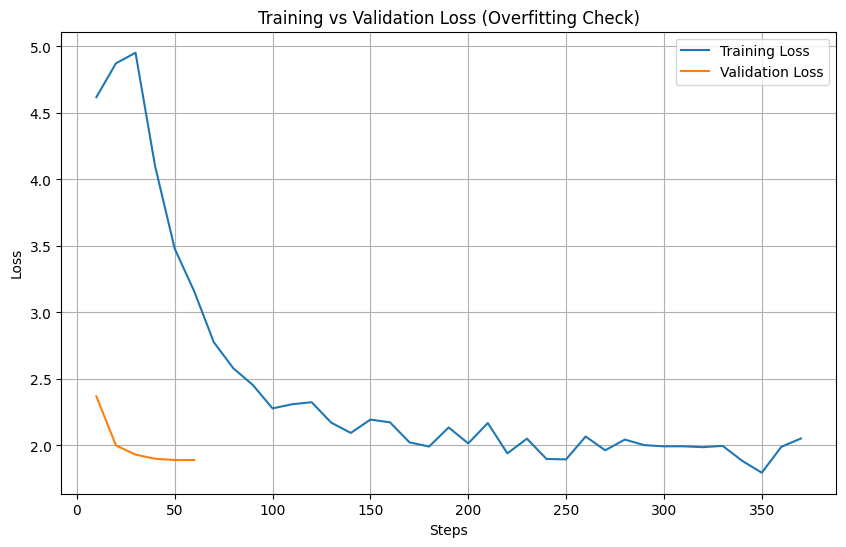

In [ ]:
logs_scifive = trainer_scifive.state.log_history

# Initialize lists to store training loss, evaluation loss, and steps
train_loss_scifive = []
eval_loss_scifive = []
steps_scifive = []

# Iterate through the log history
for entry in logs_scifive:
    if "loss" in entry:
        train_loss_scifive.append(entry["loss"])
        steps_scifive.append(entry["step"])
    elif "eval_loss" in entry:
        eval_loss_scifive.append(entry["eval_loss"])

train_steps_scifive = steps_scifive[:len(train_loss_scifive)]
eval_steps_scifive = steps_scifive[:len(eval_loss_scifive)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps_scifive, train_loss_scifive, label="Training Loss")
plt.plot(eval_steps_scifive, eval_loss_scifive, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Overfitting Check)")
plt.legend()
plt.grid(True)
plt.show()

##**Simulation**

In [ ]:
sample_eval_scifive = tokenized_val_dataset_scifive.select(range(100))

predictions_output_scifive = trainer_scifive.predict(sample_eval_scifive)

preds_scifive = predictions_output_scifive.predictions
labels_scifive = predictions_output_scifive.label_ids

if isinstance(preds_scifive, tuple):
    preds_scifive = preds_scifive[0]

if preds_scifive.ndim == 3:
    preds_scifive = np.argmax(preds_scifive, axis=-1)

labels_scifive = np.where(labels_scifive == -100, tokenizer_scifive.pad_token_id, labels_scifive)

decoded_preds_scifive = tokenizer_scifive.batch_decode(preds_scifive, skip_special_tokens=True)
decoded_labels_scifive = tokenizer_scifive.batch_decode(labels_scifive, skip_special_tokens=True)

decoded_preds_scifive = [p.strip() for p in decoded_preds_scifive]
decoded_labels_scifive = [l.strip() for l in decoded_labels_scifive]

for i in range(len(decoded_preds_scifive)):
    print(f"\n Example {i+1}")
    print(f" Prediction: {decoded_preds_scifive[i]}")
    print(f" Reference: {decoded_labels_scifive[i]}")


 Example 1
 Prediction: her patient presentation of hera 60 year old female with hypo anchromic microcytic anemia the thea history of 8 blood transfusions the investigation appropriate investigation are determine are be include  itin and determine the status and toglobin levelsphoresis. determine iron ironunderlyingalassemia. with  otherdetermining the emia such micro hemo such thisth functionrrosis is a common condition  can the overloadfic in the bloodery and  often a cause cause of ancytic anemia. this  of other laboratory symptoms. . the the anth hemo
 Reference: given the clinical context of a 60 year old woman with persistent hypochromic microcytic anemia and a history of multiple blood transfusions the most relevant investigations to consider would typically include serum ferritin to assess iron levels and hemoglobin electrophoresis to evaluate for thalassemia along with possibly assessing for anemia of chronic disease. pulmonary hemosiderosis is a rare condition that involves 

In [ ]:
# Define a function to generate an answer using the fine-tuned SciFive model
# Takes the medical 'question' and an optional 'cot' (Chain of Thought) as input
def answer_question_scifive(question, cot=""):
    # Combine the question and optional chain of thought for the model input
    full_input = question.strip().lower() + " " + cot.strip().lower()
    # Convert both question and CoT to lowercase and strip whitespace, then combine them.

    # Tokenize the input and prepare it as a PyTorch tensor
    input_ids = tokenizer_scifive(full_input, return_tensors="pt", max_length=128, truncation=True, padding="max_length").input_ids

    device = next(model_scifive.parameters()).device
    input_ids = input_ids.to(device)

    # Generate output token IDs using the model
    output_ids = model_scifive.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)

    # Decode the generated token IDs back to a string, skipping special tokens
    response = tokenizer_scifive.decode(output_ids[0], skip_special_tokens=True)

    return response

In [ ]:
model_scifive = model_scifive.to("cuda")

In [ ]:
# Start an interactive loop for asking questions, this loop allows the user to repeatedly ask questions to the SciFive model.

while True:

    domanda = input("Insert your medical question (or digit 'exit'): ")
    # Prompt the user to enter a medical question.

    # If the user types 'exit', break the loop
    if domanda.lower() == 'exit':
        break

    # Prompt the user to optionally provide a Chain of Thought (CoT).
    # This allows the user to guide the model's reasoning process.
    cot = input("Give (optionally) a chain of thought: ")

    # Call the 'answer_question_scifive' function with the user's question and CoT to get the model's generated answer.
    risposta = answer_question_scifive(domanda, cot)

    print("\n Model's answer:", risposta)
    print("-" * 50)

Insert your medical question (or digit 'exit'): what are diabetes symptoms?
Give (optionally) a chain of thought: 

 Model's answer: are the most common symptoms of type 2 diabetes?
--------------------------------------------------
Insert your medical question (or digit 'exit'): An 8-year-old boy presents with 6 months of progressive fatigue, weight loss, decreased energy, loose stools, occasional abdominal pain and nausea, tanned skin, and bluish-black gums. Serum studies indicate hyponatremia, hyperkalemia, and hypoglycemia. Based on these symptoms and laboratory findings, what is the initial step in treatment that should be administered to this patient?
Give (optionally) a chain of thought: 

 Model's answer: based on the symptoms and laboratory findings, the initial step in treatment that should be administered to this patient is to initiate treatment. based on the symptoms and laboratory findings, the initial step in treatment that should be administered to this patient is to ini

#**Comparing T5 and SciFive**
The training and validation loss curves (Figure 1) and the ROUGE score comparison (Figure 2) highlight the performance differences between the T5-Small and SciFive-base models after fine-tuning on the same biomedical dataset. SciFive demonstrates faster convergence, lower final loss, and better generalization, as evidenced by the closer alignment between its training and validation losses. In addition, SciFive achieves consistently higher ROUGE scores across all metrics (ROUGE-1, ROUGE-2, ROUGE-L, and ROUGE-Lsum), confirming its superior ability to generate accurate and relevant answers. These improvements are likely attributed to SciFive’s pretraining on domain-specific scientific texts (PubMed), making it better suited for biomedical natural language generation tasks.

These results confirm that using a language model pre-trained in the medical domain leads to more accurate and contextually appropriate responses.

In [ ]:
logs_scifive = trainer_scifive.state.log_history

# Initialize lists to store training loss, evaluation loss, and steps
train_loss_scifive = []
eval_loss_scifive = []
steps_scifive = []

# Iterate through the log history
for entry in logs_scifive:
    # Extract training and evaluation loss from the SciFive trainer's log history.
    # The log history is a list of dictionaries, where each dictionary represents a logging step during training or evaluation.
    if "loss" in entry and "eval_loss" not in entry:
        # If the entry contains 'loss' but not 'eval_loss', it's a training loss entry.
        train_loss_scifive.append(entry["loss"])
        steps_scifive.append(entry["step"])
    elif "eval_loss" in entry:
        # If the entry contains 'eval_loss', it's an evaluation loss entry.
        eval_loss_scifive.append(entry["eval_loss"])

# Align the evaluation steps with the number of evaluation loss entries.
# This ensures that evaluation steps correctly correspond to evaluation loss values.
train_steps_scifive = steps_scifive[:len(train_loss_scifive)]
eval_steps_scifive = steps_scifive[:len(eval_loss_scifive)]

# Organize the loss and step data for T5-Small and SciFive models
# Create a dictionary to hold the training and evaluation loss data for the T5-Small model.
model_a = {
    "train_loss": train_loss_t5,
    "train_steps": train_steps_t5,
    "eval_loss": eval_loss_t5,
    "eval_steps": eval_steps_t5
}

# Create a dictionary to hold the training and evaluation loss data for the SciFive model.
model_b = {
    "train_loss": train_loss_scifive,
    "train_steps": train_steps_scifive,
    "eval_loss": eval_loss_scifive,
    "eval_steps": eval_steps_scifive
}

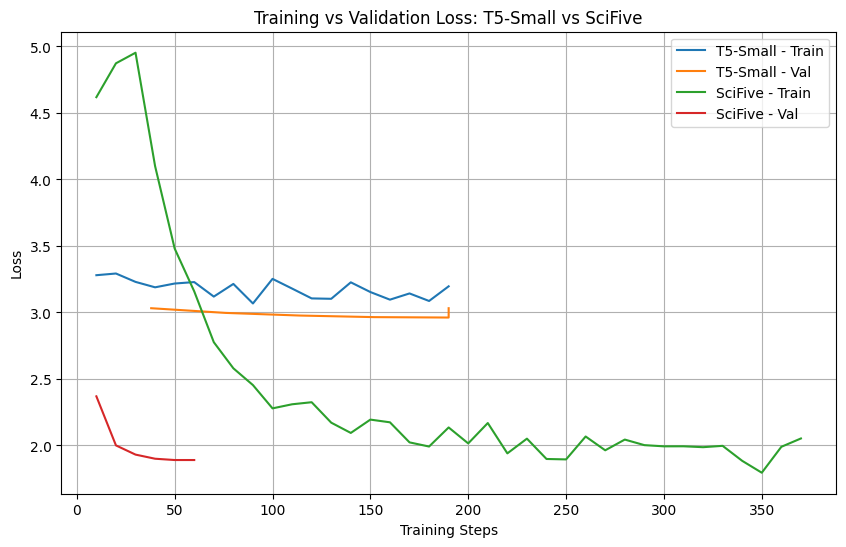

In [ ]:
# Define a function to plot the training and validation loss curves for two models.
# Takes two dictionaries (model_a and model_b) containing loss and step data.

def plot_losses_steps(model_a, model_b):
    plt.figure(figsize=(10, 6))
    plt.plot(model_a['train_steps'], model_a['train_loss'], label='T5-Small - Train')
    plt.plot(model_a['eval_steps'], model_a['eval_loss'], label='T5-Small - Val')
    plt.plot(model_b['train_steps'], model_b['train_loss'], label='SciFive - Train')
    plt.plot(model_b['eval_steps'], model_b['eval_loss'], label='SciFive - Val')
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss: T5-Small vs SciFive")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses_steps(model_a, model_b)

The plot illustrates the training and validation loss curves of the T5-Small and SciFive-base models fine-tuned on the same medical dataset. SciFive shows significantly faster convergence and lower final loss values, both in training and validation, indicating superior learning and generalization performance. In contrast, T5-Small exhibits higher loss values and signs of early overfitting, with a noticeable gap between training and validation curves.

In [ ]:
# Evaluate the fine-tuned T5-Small model on its validation dataset and store the evaluation results in 'results_t5'.
results_t5 = trainer_t5.evaluate()

# Evaluate the fine-tuned SciFive model on its validation dataset and store the evaluation results in 'results_scifive'.
results_scifive = trainer_scifive.evaluate()

Done {'rouge1': 0.47427600381573454, 'rouge2': 0.19162058920866298, 'rougeL': 0.392650008772327, 'rougeLsum': 0.39282855345863954}
Done {'rouge1': np.float64(0.47427600381573454), 'rouge2': np.float64(0.19162058920866298), 'rougeL': np.float64(0.392650008772327), 'rougeLsum': np.float64(0.39282855345863954)}
{'eval_loss': 1.8906333446502686, 'eval_rouge1': 0.5535760153138177, 'eval_rouge2': 0.25280322404598626, 'eval_rougeL': 0.47725593865311655, 'eval_rougeLsum': 0.4775434518730025, 'eval_runtime': 10.0743, 'eval_samples_per_second': 19.852, 'eval_steps_per_second': 2.482, 'epoch': 5.0}


In [ ]:
print("T5-Small ROUGE scores:")
for k, v in results_t5.items():
    if "rouge" in k:
        print(f"{k}: {v:.4f}")

print("SciFive ROUGE scores:")
for k, v in results_scifive.items():
    if "rouge" in k:
        print(f"{k}: {v:.4f}")

T5-Small ROUGE scores:
eval_rouge1: 0.4743
eval_rouge2: 0.1916
eval_rougeL: 0.3927
eval_rougeLsum: 0.3928
SciFive ROUGE scores:
eval_rouge1: 0.5536
eval_rouge2: 0.2528
eval_rougeL: 0.4773
eval_rougeLsum: 0.4775


In [ ]:
# Initialize a dictionary to store ROUGE scores for comparison in a structured format.
# This dictionary will be used to create a Pandas DataFrame for display.
rouge_comparison = {
    "Metric": [],
    "T5-Small": [],
    "SciFive": []
}

for k in results_t5:
    if "rouge" in k:
        rouge_comparison["Metric"].append(k)
        rouge_comparison["T5-Small"].append(results_t5[k])
        rouge_comparison["SciFive"].append(results_scifive[k])

df = pd.DataFrame(rouge_comparison)
display(df)

,Metric,T5-Small,SciFive
0,eval_rouge1,0.474276,0.553576
1,eval_rouge2,0.191621,0.252803
2,eval_rougeL,0.392650,0.477256
3,eval_rougeLsum,0.392829,0.477543


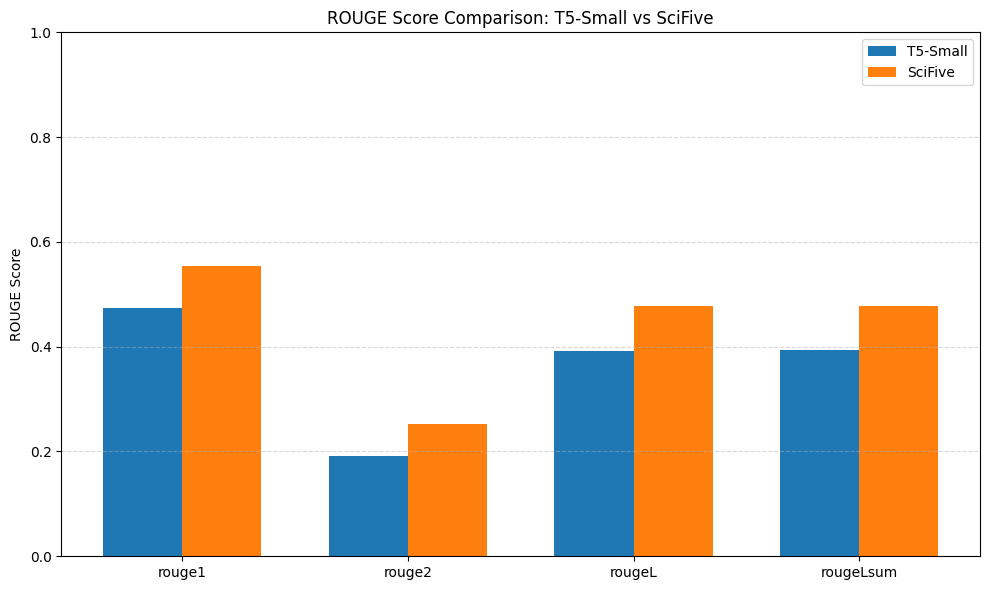

In [ ]:
# Define a list of ROUGE metric names that will be used for plotting.
rouge_metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_keys = [f"eval_{m}" for m in rouge_metrics]

# Extract the ROUGE scores for T5-Small using the defined keys.
t5_scores = [results_t5[k] for k in rouge_keys]
# Extract the ROUGE scores for T5-Small using the defined keys.
scifive_scores = [results_scifive[k] for k in rouge_keys]

x = range(len(rouge_metrics))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], t5_scores, width=bar_width, label='T5-Small')
plt.bar([i + bar_width/2 for i in x], scifive_scores, width=bar_width, label='SciFive')

plt.xticks(x, rouge_metrics)
plt.ylabel("ROUGE Score")
plt.title("ROUGE Score Comparison: T5-Small vs SciFive")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

This bar chart compares the ROUGE-1, ROUGE-2, ROUGE-L, and ROUGE-Lsum scores obtained by the T5-Small and SciFive-base models after fine-tuning on the same medical dataset. Across all metrics, SciFive consistently outperforms T5-Small, showing higher scores in unigram overlap (ROUGE-1), bigram overlap (ROUGE-2), longest common subsequence (ROUGE-L), and summarization-focused variants (ROUGE-Lsum). These results indicate that SciFive generates responses more aligned with the reference texts, likely due to its biomedical pretraining on PubMed abstracts.

# **Phi-3-mini Model**
A lightweight, decoder-only language model developed by Microsoft. Phi-3 is optimized for instruction following, efficiency, and safety, and shows strong performance in medical Q&A tasks with minimal prompting.

## Importing Model

In [ ]:
# Load the tokenizer associated with the specified Phi-3-mini model.
model_name_phi = "microsoft/phi-3-mini-4k-instruct"
tokenizer_phi = AutoTokenizer.from_pretrained(model_name_phi)

# Load the pre-trained Phi-3-mini model for Causal Language Modeling (decoder-only).
model_phi = AutoModelForCausalLM.from_pretrained(model_name_phi, device_map="auto", torch_dtype=torch.float16)

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

## Prompt Engineering

In [ ]:
# Define a function to generate an answer using the loaded Phi-3 model based on a given prompt.
def generate_phi_answer(prompt, max_new_tokens=100):

    # Tokenize the input 'prompt' and convert it to PyTorch tensors.
    # 'max_length=512' sets the maximum input sequence length.
    # 'truncation=True' truncates the input if it exceeds max_length.
    inputs = tokenizer_phi(prompt, return_tensors="pt", max_length=512, truncation=True).to(model_phi.device)

    outputs = model_phi.generate(
        # Use the model's 'generate' method to produce text based on the input.
        **inputs,
        # Pass the tokenized inputs to the generation function.
        max_new_tokens=max_new_tokens,
        # Limit the number of new tokens generated for the answer.
        num_beams=1,
        do_sample=False,
        pad_token_id=tokenizer_phi.eos_token_id
    )

    # Decode the generated token IDs (the first output sequence) back into a string.
    full_text = tokenizer_phi.decode(outputs[0], skip_special_tokens=True)
    # 'skip_special_tokens=True' removes special tokens.

    # Remove the original prompt from the generated full text to isolate just the answer.
    answer = full_text.replace(prompt, "").strip()
    # '.strip()' removes leading/trailing whitespace from the extracted answer.

    # This is a safety check to remove any potential leftover "Question:" markers that the model might erroneously generate after the answer in a multi-turn-like format.
    if "\nQuestion:" in answer:
        answer = answer.split("\nQuestion:")[0].strip()

    return answer

In [ ]:
# Define a function to create a "zero-shot" prompt for the Phi-3 model.
# In zero-shot prompting, the model is given only the task instruction and the input.
def build_zero_shot_prompt_phi(question, context=None):

    # Start the prompt with an instruction to the model about its persona/role.
    prompt = "You are a helpful medical assistant.\n\n"

    if context:
        prompt += f"Context: {context.strip()}\n"
    prompt += f"Question: {question.strip()}\nAnswer:"
    # The model is expected to generate the answer after the "Answer:" tag.

    return prompt

In [ ]:
# Define a function to create a "one-shot" prompt for the Phi-3 model.
# In one-shot prompting, one example of an input-output pair is provided along with the new input.
def build_one_shot_prompt_phi(question, context=None, example=None):

    # Start the prompt with the same role instruction.
    prompt = "You are a helpful medical assistant.\n\n"
    if example:
        prompt += f"Example:\nQuestion: {example['Question']}\nAnswer: {example['Response']}\n\n"

    if context:
        prompt += f"Context: {context.strip()}\n"
    prompt += f"Question: {question.strip()}\nAnswer:"
    # The model is expected to generate the answer after the "Answer:" tag.

    return prompt

In [ ]:
# Define a function to create a "few-shot" prompt for the Phi-3 model.
# In few-shot prompting, multiple examples of input-output pairs are provided.
def build_few_shot_prompt_phi(question, context=None, example=None):
    prompt = "You are a helpful medical assistant. Answer the following questions:\n\n"
    for ex in examples:
        prompt += f"Question: {ex['Question']}\nAnswer: {ex['Response']}\n\n"
    if context:
        prompt += f"Context: {context.strip()}\n"
    prompt += f"Question: {question.strip()}\nAnswer:"
    # Add the new 'question' at the end for the model to answer.

    return prompt

## Simulation with Prompt Engineering

In [ ]:
# Define a sample medical question to be used for demonstration.
question = "What are the symptoms of type 1 diabetes?"

# Define an optional context related to the question.
context = "Type 1 diabetes can include symptoms like increased thirst, frequent urination, fatigue, and weight loss."

# Example for one-shot and few-shot
example = {
    "Question": "What is the treatment for hypertension?",
    "Response": "The treatment typically involves lifestyle changes and medications such as ACE inhibitors or beta blockers."
}

# Define a list of examples to be used for few-shot prompting. It includes the 'example' defined above.
examples = [
    example,
    {
        "Question": "What causes asthma?",
        "Response": "Asthma can be caused by allergens, respiratory infections, physical activity, or environmental factors."
    },
    {
        "Question": "What is the main risk factor for heart disease?",
        "Response": "The main risk factor for heart disease is high blood pressure."
    }
]

# Zero-shot
prompt_zero = build_zero_shot_prompt_phi(question, context)
print("Zero-shot:\n", generate_phi_answer(prompt_zero))

# One-shot
prompt_one = build_one_shot_prompt_phi(question, context, example)
print("\nOne-shot:\n", generate_phi_answer(prompt_one))

# Few-shot
prompt_few = build_few_shot_prompt_phi(question, context, examples)
print("\nFew-shot:\n", generate_phi_answer(prompt_few))

Zero-shot:
 The symptoms of type 1 diabetes include increased thirst, frequent urination, fatigue, and weight loss.

One-shot:
 The symptoms include increased thirst, frequent urination, fatigue, and weight loss.

Few-shot:
 The symptoms of type 1 diabetes include increased thirst, frequent urination, fatigue, and weight loss.


### Zero-shot

In [ ]:
# Select the first example from the test dataset. This example will be used
# to demonstrate zero-shot prompting.
sample = test_dataset[0]

# Build a zero-shot prompt using the "Question" field of the selected test sample.
# No context or examples are provided in a zero-shot prompt.
prompt = build_zero_shot_prompt_phi(sample["Question"])

# Generate the model's answer using the constructed zero-shot prompt.
answer = generate_phi_answer(prompt)

print("Prompt:\n", prompt)
print("\nModel Answer:\n", answer)
print("\nGround Truth CoT:\n", sample["Complex_CoT"])

Prompt:
 You are a helpful medical assistant.

Question: a six year old male child has been experiencing recurrent gross hematuria for the past two years. there is no history of burning micturition or pyuria and urine routine examination shows no pus cells with a sterile urine culture. serum c3 levels are normal. based on these clinical findings and laboratory results what is the most probable diagnosis?
Answer:

Model Answer:
 The most probable diagnosis for a six-year-old male child with recurrent gross hematuria, no history of burning micturition or pyuria, and normal serum C3 levels is IgA nephropathy (Berger's disease). IgA nephropathy is a common cause of glomerulonephritis in children and can present with episodic gross hematuria, often following a respiratory or gastrointest

Ground Truth CoT:
 alright let s think this through slowly. we ve got a young boy six years old who s been facing episodes of gross hematuria. it s popping up repeatedly over the past couple of years. now 

### One-shot

In [ ]:
# Select the first 3 examples from the training dataset to use as one-shot examples
one_shot_example = train_dataset.select(range(1))[0]

sample = test_dataset[0]
# Build the one-shot prompt using the a selected example and the question from the test sample
prompt = build_one_shot_prompt_phi(sample["Question"], example=one_shot_example)
# Generate the model's answer using the constructed one-shot prompt
answer = generate_phi_answer(prompt)

print("Prompt One-shot:\n", prompt)
print("\nModel Answer (One-shot):\n", answer)
print("\nGround Truth CoT:\n", sample["Complex_CoT"])

Prompt One-shot:
 You are a helpful medical assistant.

Example:
Question: Given the symptoms of sudden weakness in the left arm and leg, recent long-distance travel, and the presence of swollen and tender right lower leg, what specific cardiac abnormality is most likely to be found upon further evaluation that could explain these findings?
Answer: The specific cardiac abnormality most likely to be found in this scenario is a patent foramen ovale (PFO). This condition could allow a blood clot from the venous system, such as one from a deep vein thrombosis in the leg, to bypass the lungs and pass directly into the arterial circulation. This can occur when the clot moves from the right atrium to the left atrium through the PFO. Once in the arterial system, the clot can travel to the brain, potentially causing an embolic stroke, which would explain the sudden weakness in the left arm and leg. The connection between the recent travel, which increases the risk of deep vein thrombosis, and t

###Few-shot

In [ ]:
# Select the first 3 examples from the training dataset to use as few-shot examples
few_shot_examples = train_dataset.select(range(3))

sample = test_dataset[0]
# Build the few-shot prompt using the selected few-shot examples and the question from the test sample
prompt = build_few_shot_prompt_phi(sample["Question"], example=few_shot_examples)
# Generate the model's answer using the constructed few-shot prompt
answer = generate_phi_answer(prompt)

print("Prompt Few-shot:\n", prompt)
print("\nModel Answer (Few-shot):\n", answer)
print("\nGround Truth CoT:\n", sample["Complex_CoT"])

Prompt Few-shot:
 You are a helpful medical assistant. Answer the following questions:

Question: What is the treatment for hypertension?
Answer: The treatment typically involves lifestyle changes and medications such as ACE inhibitors or beta blockers.

Question: What causes asthma?
Answer: Asthma can be caused by allergens, respiratory infections, physical activity, or environmental factors.

Question: What is the main risk factor for heart disease?
Answer: The main risk factor for heart disease is high blood pressure.

Question: a six year old male child has been experiencing recurrent gross hematuria for the past two years. there is no history of burning micturition or pyuria and urine routine examination shows no pus cells with a sterile urine culture. serum c3 levels are normal. based on these clinical findings and laboratory results what is the most probable diagnosis?
Answer:

Model Answer (Few-shot):
 The most probable diagnosis for this child is IgA nephropathy (Berger's dise

##Evaluation

In [ ]:
!pip install -q datasets transformers torch peft evaluate accelerate sentencepiece
!pip install -q rouge-score nltk
!pip install -q bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
from tqdm.auto import tqdm

In [ ]:
# Uploding metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

def evaluate_model_phi(dataset, prompt_builder, generate_phi_answer, reference_field="Response", num_examples=0):
    predictions = []
    references = []

    for item in tqdm(dataset):
        if num_examples == 0:
            prompt = prompt_builder(item["Question"])
        else:
            examples = train_dataset.select(range(num_examples))
            # Pass the question and examples to the prompt_builder
            prompt = prompt_builder(item["Question"], example=examples)

        generated_answer = generate_phi_answer(prompt)

        predictions.append(generated_answer)
        references.append(item[reference_field])

    # ROUGE Evaluation
    rouge_results = rouge.compute(
        predictions=predictions,
        references=references,
        use_stemmer=True
    )

    #BLEU Evaluation
    bleu_results = bleu.compute(
        predictions=predictions,
        references=[[ref] for ref in references]
    )

    # BERTScore Evaluation
    bert_results = bertscore.compute(
        predictions=predictions,
        references=references,
        lang="en"
    )
    avg_bertscore = np.mean(bert_results["f1"]) if bert_results["f1"] else 0.0

    return {
        "rouge": rouge_results,
        "bleu": bleu_results,
        "bertscore": avg_bertscore
    }


In [ ]:
# Compute Evaluation
test_subset = test_dataset.select(range(30))

In [ ]:
print("Evaluation zero-shot:")
zero_shot_results_phi = evaluate_model_phi(test_subset, build_zero_shot_prompt_phi, generate_phi_answer)
print(f"ROUGE-L: {zero_shot_results_phi['rouge']['rougeL']:.3f}")
print(f"BLEU: {zero_shot_results_phi['bleu']['bleu']:.3f}")
print(f"BERTScore: {zero_shot_results_phi['bertscore']:.3f}")

Evaluation zero-shot:


  0%|          | 0/30 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-L: 0.285
BLEU: 0.064
BERTScore: 0.875


In [ ]:
for i in range(5):
    print(f"\nQUESTION: {test_subset[i]['Question']}")
    print(f"EXPECTED: {test_subset[i]['Response']}")
    print(f"PREDICTED: {generate_phi_answer(build_zero_shot_prompt_phi(test_subset[i]['Question']))}")


QUESTION: a six year old male child has been experiencing recurrent gross hematuria for the past two years. there is no history of burning micturition or pyuria and urine routine examination shows no pus cells with a sterile urine culture. serum c3 levels are normal. based on these clinical findings and laboratory results what is the most probable diagnosis?
EXPECTED: based on the clinical presentation of recurrent gross hematuria in a six year old male child with normal serum c3 levels no signs of urinary tract infection and the absence of pus cells on urinalysis the most probable diagnosis is iga nephropathy. iga nephropathy also known as berger s disease commonly presents with recurrent gross hematuria in children and is often associated with infections even though explicit preceding infections are not mentioned here. though alternative considerations such as alport syndrome thin basement membrane nephropathy and hypercalciuria exist these either have additional distinctive clinica

In [ ]:
print("Evaluation one-shot:")
one_shot_results_phi = evaluate_model_phi(test_subset, build_one_shot_prompt_phi, generate_phi_answer, num_examples=1)
print(f"ROUGE-L: {one_shot_results_phi['rouge']['rougeL']:.3f}")
print(f"BLEU: {one_shot_results_phi['bleu']['bleu']:.3f}")
print(f"BERTScore: {one_shot_results_phi['bertscore']:.3f}")

Evaluation one-shot:


  0%|          | 0/30 [00:00<?, ?it/s]

ROUGE-L: 0.282
BLEU: 0.075
BERTScore: 0.871


In [ ]:
for i in range(5):
    print(f"\nQUESTION: {test_subset[i]['Question']}")
    print(f"EXPECTED: {test_subset[i]['Response']}")
    print(f"PREDICTED: {generate_phi_answer(build_one_shot_prompt_phi(test_subset[i]['Question']))}")


QUESTION: a six year old male child has been experiencing recurrent gross hematuria for the past two years. there is no history of burning micturition or pyuria and urine routine examination shows no pus cells with a sterile urine culture. serum c3 levels are normal. based on these clinical findings and laboratory results what is the most probable diagnosis?
EXPECTED: based on the clinical presentation of recurrent gross hematuria in a six year old male child with normal serum c3 levels no signs of urinary tract infection and the absence of pus cells on urinalysis the most probable diagnosis is iga nephropathy. iga nephropathy also known as berger s disease commonly presents with recurrent gross hematuria in children and is often associated with infections even though explicit preceding infections are not mentioned here. though alternative considerations such as alport syndrome thin basement membrane nephropathy and hypercalciuria exist these either have additional distinctive clinica

In [ ]:
print("\nEvaluation few-shot (3 examples):")
few_shot_results_phi = evaluate_model_phi(test_subset, build_one_shot_prompt_phi, generate_phi_answer, num_examples=3)
print(f"ROUGE-L: {few_shot_results_phi['rouge']['rougeL']:.3f}")
print(f"BLEU: {few_shot_results_phi['bleu']['bleu']:.3f}")
print(f"BERTScore: {few_shot_results_phi['bertscore']:.3f}")


Evaluation few-shot (3 examples):


  0%|          | 0/30 [00:00<?, ?it/s]

ROUGE-L: 0.027
BLEU: 0.000
BERTScore: 0.810


In [ ]:
for i in range(5):
    print(f"\nQUESTION: {test_subset[i]['Question']}")
    print(f"EXPECTED: {test_subset[i]['Response']}")
    print(f"PREDICTED: {generate_phi_answer(build_few_shot_prompt_phi(test_subset[i]['Question'], example=few_shot_examples))}")


QUESTION: a six year old male child has been experiencing recurrent gross hematuria for the past two years. there is no history of burning micturition or pyuria and urine routine examination shows no pus cells with a sterile urine culture. serum c3 levels are normal. based on these clinical findings and laboratory results what is the most probable diagnosis?
EXPECTED: based on the clinical presentation of recurrent gross hematuria in a six year old male child with normal serum c3 levels no signs of urinary tract infection and the absence of pus cells on urinalysis the most probable diagnosis is iga nephropathy. iga nephropathy also known as berger s disease commonly presents with recurrent gross hematuria in children and is often associated with infections even though explicit preceding infections are not mentioned here. though alternative considerations such as alport syndrome thin basement membrane nephropathy and hypercalciuria exist these either have additional distinctive clinica

## Visualization

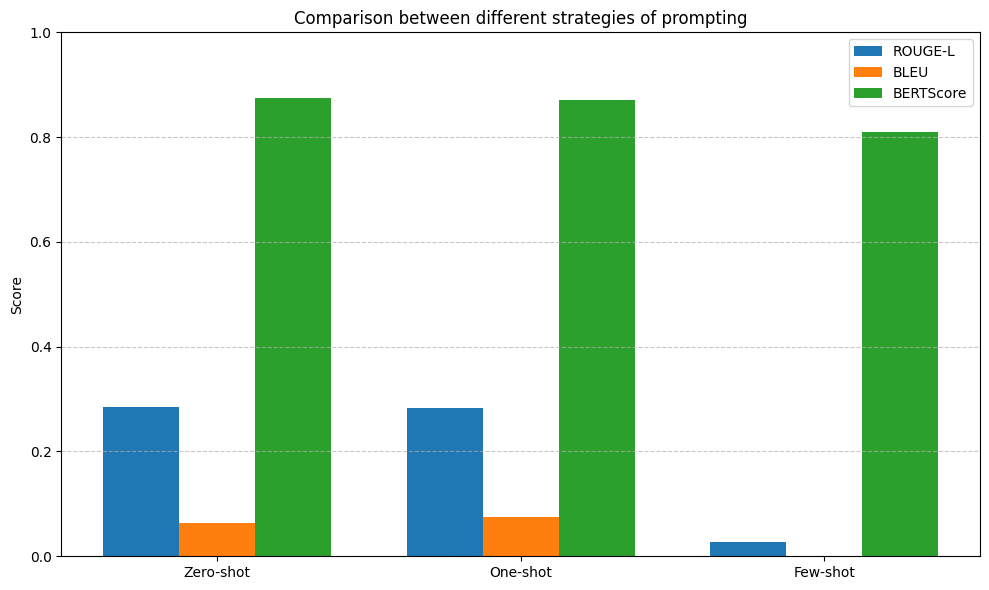

In [ ]:
# Collect the data
prompting_methods = ['Zero-shot', 'One-shot', 'Few-shot']

# Extract ROUGE-L scores
rouge_scores_phi = [
    zero_shot_results_phi['rouge']['rougeL'],
    one_shot_results_phi['rouge']['rougeL'],
    few_shot_results_phi['rouge']['rougeL']
]

# Extract BLEU scores
bleu_scores_phi = [
    zero_shot_results_phi['bleu']['bleu'],
    one_shot_results_phi['bleu']['bleu'],
    few_shot_results_phi['bleu']['bleu']
]

# Extract BERTScore values
bertscore_scores_phi = [
    zero_shot_results_phi['bertscore'],
    one_shot_results_phi['bertscore'],
    few_shot_results_phi['bertscore']
]

# Prepare the plot
x = range(len(prompting_methods))
bar_width = 0.25

plt.figure(figsize=(10, 6))

# Plot ROUGE-L, BLEU, and BERTScore side by side
plt.bar([i - bar_width for i in x], rouge_scores_phi, width=bar_width, label='ROUGE-L')
plt.bar(x, bleu_scores_phi, width=bar_width, label='BLEU')
plt.bar([i + bar_width for i in x], bertscore_scores_phi, width=bar_width, label='BERTScore')

# Customize plot
plt.xticks(x, prompting_methods)
plt.ylabel('Score')
plt.title('Comparison between different strategies of prompting')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


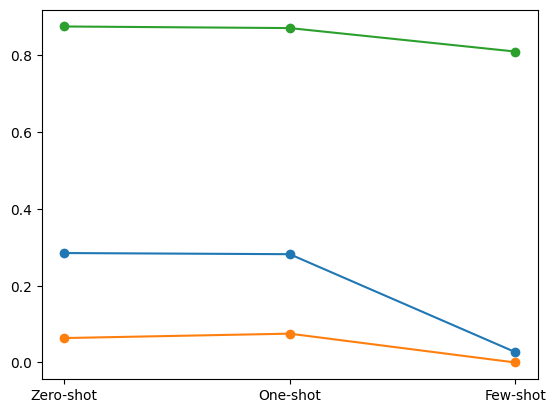

In [ ]:
# Line plot comparison of prompting strategies

# Plot ROUGE-L, BLEU, and BERTScore as lines with markers
plt.plot(prompting_methods, rouge_scores_phi, marker='o', label='ROUGE-L')
plt.plot(prompting_methods, bleu_scores_phi, marker='o', label='BLEU')
plt.plot(prompting_methods, bertscore_scores_phi, marker='o', label='BERTScore')

## Interactive Simulation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_phi = model_phi.to(device)

In [ ]:
def answer_question_phi(question, cot=""):
    # Build prompt in dialogue format
    prompt = f"User: {question.strip()}\n"
    if cot.strip():
        prompt += f"{cot.strip()}\n"
    prompt += "Assistant:"

    # Tokenize the prompt
    inputs = tokenizer_phi(prompt, return_tensors="pt", max_length=4096, truncation=True)
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Generate the output from the model
    output_ids = model_phi.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=256,
        num_beams=4,
        early_stopping=True,
        do_sample=False
    )

    # Decode only the newly generated part (excluding the prompt)
    generated = output_ids[0][input_ids.shape[1]:]
    response = tokenizer_phi.decode(generated, skip_special_tokens=True).strip()

    # Truncate response if the model starts a new dialogue turn
    response = response.split("User:")[0].strip()

    return response


In [ ]:
if __name__ == "__main__":
    print("Interactive Q&A (digit 'exit' to stop):")
    while True:

      # Get user question
        domanda = input("Insert your question: ")
        if domanda.lower() == "exit":
            break

        # Optional chain of thought input
        cot = input("Insert your chain of thought (optional): ")

        # Generate and display the model's answer
        risposta = answer_question_phi(domanda, cot)
        print("\nAnswer:\n", risposta)
        print("-" * 50)

Interactive Q&A (digit 'exit' to stop):
Insert your question: what are diabetes symptoms?
Insert your chain of thought (optional): 

Answer:
 Common symptoms of diabetes include increased thirst, frequent urination, hunger, fatigue, blurred vision, slow-healing sores, frequent infections, and unexplained weight loss. It's important to consult a healthcare professional for proper diagnosis and treatment.
--------------------------------------------------
Insert your question: An 8-year-old boy presents with 6 months of progressive fatigue, weight loss, decreased energy, loose stools, occasional abdominal pain and nausea, tanned skin, and bluish-black gums. Serum studies indicate hyponatremia, hyperkalemia, and hypoglycemia. Based on these symptoms and laboratory findings, what is the initial step in treatment that should be administered to this patient?
Insert your chain of thought (optional): 

Answer:
 The symptoms and laboratory findings described for the 8-year-old boy are suggestiv

# **Flan-T5 Model**
An instruction-tuned variant of T5 trained to follow natural-language prompts. Flan-T5 demonstrates strong zero-shot and few-shot generalization, although it is not specialized for clinical or biomedical domains.

## Importing Model

In [ ]:
# Load the model name
model_name_flan = "google/flan-t5-large"

# Load tokenizer
tokenizer_flan = AutoTokenizer.from_pretrained(model_name_flan)

# Load model and move it to GPU if available
model_flan = AutoModelForSeq2SeqLM.from_pretrained(model_name_flan).to("cuda" if torch.cuda.is_available() else "cpu")

# Enable gradient checkpointing to reduce memory usage during training
model_flan.gradient_checkpointing_enable()

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Prompt Engineering

In [ ]:
# Zero-shot prompt: no examples provided
def build_zero_shot_prompt_flan(question, context=None):
    prompt = "You are a helpful medical assistant.\n"
    if context:
        prompt += f"Context: {context.strip()}\n"
    prompt += f"Question: {question.strip()}\nAnswer:"
    return prompt

In [ ]:
# One-shot prompt: one example provided before the actual question
def build_one_shot_prompt_flan(question, context=None, example=None):
    prompt = "You are a helpful medical assistant.\n\n"
    if example:
        prompt += f"Example:\nQuestion: {example['Question']}\nAnswer: {example['Response']}\n\n"
    if context:
        prompt += f"Context: {context.strip()}\n"
    prompt += f"Question: {question.strip()}\nAnswer:"
    return prompt

In [ ]:
# Few-shot prompt: multiple examples provided before the question
def build_few_shot_prompt_flan(question, context=None, example=None):
    prompt = "You are a helpful medical assistant. Answer the following questions:\n\n"
    for ex in example:
        prompt += f"Question: {ex['Question']}\nAnswer: {ex['Response']}\n\n"
    if context:
        prompt += f"Context: {context.strip()}\n"
    prompt += f"Question: {question.strip()}\nAnswer:"
    return prompt

In [ ]:
# Generate answer using Flan-T5
def generate_flan_answer(prompt):
    # Tokenize the prompt and move it to the correct device
    inputs = tokenizer_flan(prompt, return_tensors="pt", max_length=512, truncation=True).to(model_flan.device)
    # Generate the response
    outputs = model_flan.generate(**inputs, max_new_tokens=200)
    # Decode and return the answer
    return tokenizer_flan.decode(outputs[0], skip_special_tokens=True).strip()

## Simulation with Prompt Engineering

In [ ]:
question = "What are the symptoms of type 1 diabetes?"
context = "Type 1 diabetes can include symptoms like increased thirst, frequent urination, fatigue, and weight loss."

# Example for one-shot and few-shot
example = {
    "Question": "What is the treatment for hypertension?",
    "Response": "The treatment typically involves lifestyle changes and medications such as ACE inhibitors or beta blockers."
}

examples = [
    example,
    {
        "Question": "What causes asthma?",
        "Response": "Asthma can be caused by allergens, respiratory infections, physical activity, or environmental factors."
    },
    {
        "Question": "What is the main risk factor for heart disease?",
        "Response": "The main risk factor for heart disease is high blood pressure."
    }
]

# Zero-shot
prompt_zero = build_zero_shot_prompt_flan(question, context)
print("Zero-shot:\n", generate_flan_answer(prompt_zero))

# One-shot
prompt_one = build_one_shot_prompt_flan(question, context, example)
print("\nOne-shot:\n", generate_flan_answer(prompt_one))

# Few-shot
prompt_few = build_few_shot_prompt_flan(question, context, examples)
print("\nFew-shot:\n", generate_flan_answer(prompt_few))

Zero-shot:
 increased thirst, frequent urination, fatigue, and weight loss

One-shot:
 increased thirst, frequent urination, fatigue, and weight loss

Few-shot:
 Type 1 diabetes can include symptoms like increased thirst, frequent urination, fatigue, and weight loss.


### Zero-shot

In [ ]:
sample = test_dataset[0]
prompt = build_zero_shot_prompt_flan(sample["Question"])
answer = generate_flan_answer(prompt)

print("Prompt:\n", prompt)
print("\nModel Answer:\n", answer)
print("\nGround Truth CoT:\n", sample["Complex_CoT"])

Prompt:
 You are a helpful medical assistant.
Question: a six year old male child has been experiencing recurrent gross hematuria for the past two years. there is no history of burning micturition or pyuria and urine routine examination shows no pus cells with a sterile urine culture. serum c3 levels are normal. based on these clinical findings and laboratory results what is the most probable diagnosis?
Answer:

Model Answer:
 uremic syndrome

Ground Truth CoT:
 alright let s think this through slowly. we ve got a young boy six years old who s been facing episodes of gross hematuria. it s popping up repeatedly over the past couple of years. now there are no signs of discomfort when peeing—no burning or pyuria which suggests this isn t likely an infection. a sterile urine culture further supports that point ruling out typical urinary tract infections. oh and the serum c3 levels are normal. that s an important clue low c3 levels usually point towards certain kidney conditions like post s

### One-shot

In [ ]:
one_shot_example = train_dataset.select(range(1))[0]

sample = test_dataset[0]
prompt = build_one_shot_prompt_flan(sample["Question"], example=one_shot_example)
answer = generate_flan_answer(prompt)

print("Prompt One-shot:\n", prompt)
print("\nModel Answer (One-shot):\n", answer)
print("\nGround Truth CoT:\n", sample["Complex_CoT"])

Prompt One-shot:
 You are a helpful medical assistant.

Example:
Question: Given the symptoms of sudden weakness in the left arm and leg, recent long-distance travel, and the presence of swollen and tender right lower leg, what specific cardiac abnormality is most likely to be found upon further evaluation that could explain these findings?
Answer: The specific cardiac abnormality most likely to be found in this scenario is a patent foramen ovale (PFO). This condition could allow a blood clot from the venous system, such as one from a deep vein thrombosis in the leg, to bypass the lungs and pass directly into the arterial circulation. This can occur when the clot moves from the right atrium to the left atrium through the PFO. Once in the arterial system, the clot can travel to the brain, potentially causing an embolic stroke, which would explain the sudden weakness in the left arm and leg. The connection between the recent travel, which increases the risk of deep vein thrombosis, and t

###Few-shot

In [ ]:
few_shot_examples = train_dataset.select(range(3))

sample = test_dataset[0]
prompt = build_few_shot_prompt_flan(sample["Question"], example=few_shot_examples) # Passa la lista di esempi!
answer = generate_flan_answer(prompt)

print("Prompt Few-shot:\n", prompt)
print("\nModel Answer (Few-shot):\n", answer)
print("\nGround Truth CoT:\n", sample["Complex_CoT"])

Prompt Few-shot:
 You are a helpful medical assistant. Answer the following questions:

Question: Given the symptoms of sudden weakness in the left arm and leg, recent long-distance travel, and the presence of swollen and tender right lower leg, what specific cardiac abnormality is most likely to be found upon further evaluation that could explain these findings?
Answer: The specific cardiac abnormality most likely to be found in this scenario is a patent foramen ovale (PFO). This condition could allow a blood clot from the venous system, such as one from a deep vein thrombosis in the leg, to bypass the lungs and pass directly into the arterial circulation. This can occur when the clot moves from the right atrium to the left atrium through the PFO. Once in the arterial system, the clot can travel to the brain, potentially causing an embolic stroke, which would explain the sudden weakness in the left arm and leg. The connection between the recent travel, which increases the risk of deep

## Evaluation

In [ ]:
# Load evaluation metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

def evaluate_model_flan(dataset, prompt_builder, generate_flan_answer, reference_field="Response", num_examples=0):
    predictions = []
    references = []

   # Loop through each item in the evaluation dataset
    for item in tqdm(dataset):
        if num_examples == 0:
          # Zero-shot: no examples provided
            prompt = prompt_builder(item["Question"])
        else:
          # One-shot or few-shot: select examples from training set
            examples = train_dataset.select(range(num_examples))
            # Pass the question and examples to the prompt_builder
            prompt = prompt_builder(item["Question"], example=examples)

        # Generate answer using the model
        generated_answer = generate_flan_answer(prompt)

        # Save prediction and corresponding ground truth
        predictions.append(generated_answer)
        references.append(item[reference_field])

    # Compute ROUGE scores
    rouge_results = rouge.compute(
        predictions=predictions,
        references=references,
        use_stemmer=True
    )

    # Compute BLEU scores
    bleu_results = bleu.compute(
        predictions=predictions,
        references=[[ref] for ref in references]
    )

    # Compute BERTScore
    bert_results = bertscore.compute(
        predictions=predictions,
        references=references,
        lang="en"
    )
    avg_bertscore = np.mean(bert_results["f1"]) if bert_results["f1"] else 0.0

    # Return all three metrics
    return {
        "rouge": rouge_results,
        "bleu": bleu_results,
        "bertscore": avg_bertscore
    }


In [ ]:
#Compute Evaluation
test_subset = test_dataset.select(range(10))

In [ ]:
print("Evaluation zero-shot:")
zero_shot_results_flan = evaluate_model_flan(test_subset, build_zero_shot_prompt_flan, generate_flan_answer)
print(f"ROUGE-L: {zero_shot_results_flan['rouge']['rougeL']:.3f}")
print(f"BLEU: {zero_shot_results_flan['bleu']['bleu']:.3f}")
print(f"BERTScore: {zero_shot_results_flan['bertscore']:.3f}")

Evaluation zero-shot:


  0%|          | 0/10 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-L: 0.004
BLEU: 0.000
BERTScore: 0.772


In [ ]:
for i in range(5):
    print(f"\nQUESTION: {test_subset[i]['Question']}")
    print(f"EXPECTED: {test_subset[i]['Response']}")
    print(f"PREDICTED: {generate_flan_answer(build_zero_shot_prompt_flan(test_subset[i]['Question']))}")


QUESTION: a six year old male child has been experiencing recurrent gross hematuria for the past two years. there is no history of burning micturition or pyuria and urine routine examination shows no pus cells with a sterile urine culture. serum c3 levels are normal. based on these clinical findings and laboratory results what is the most probable diagnosis?
EXPECTED: based on the clinical presentation of recurrent gross hematuria in a six year old male child with normal serum c3 levels no signs of urinary tract infection and the absence of pus cells on urinalysis the most probable diagnosis is iga nephropathy. iga nephropathy also known as berger s disease commonly presents with recurrent gross hematuria in children and is often associated with infections even though explicit preceding infections are not mentioned here. though alternative considerations such as alport syndrome thin basement membrane nephropathy and hypercalciuria exist these either have additional distinctive clinica

In [ ]:
print("Evaluation one-shot:")
one_shot_results_flan = evaluate_model_flan(test_subset, build_one_shot_prompt_flan, generate_flan_answer, num_examples=1)
print(f"ROUGE-L: {one_shot_results_flan['rouge']['rougeL']:.3f}")
print(f"BLEU: {one_shot_results_flan['bleu']['bleu']:.3f}")
print(f"BERTScore: {one_shot_results_flan['bertscore']:.3f}")

Evaluation one-shot:


  0%|          | 0/10 [00:00<?, ?it/s]

ROUGE-L: 0.018
BLEU: 0.000
BERTScore: 0.791


In [ ]:
for i in range(5):
    print(f"\nQUESTION: {test_subset[i]['Question']}")
    print(f"EXPECTED: {test_subset[i]['Response']}")
    print(f"PREDICTED: {generate_flan_answer(build_one_shot_prompt_flan(test_subset[i]['Question']))}")


QUESTION: a six year old male child has been experiencing recurrent gross hematuria for the past two years. there is no history of burning micturition or pyuria and urine routine examination shows no pus cells with a sterile urine culture. serum c3 levels are normal. based on these clinical findings and laboratory results what is the most probable diagnosis?
EXPECTED: based on the clinical presentation of recurrent gross hematuria in a six year old male child with normal serum c3 levels no signs of urinary tract infection and the absence of pus cells on urinalysis the most probable diagnosis is iga nephropathy. iga nephropathy also known as berger s disease commonly presents with recurrent gross hematuria in children and is often associated with infections even though explicit preceding infections are not mentioned here. though alternative considerations such as alport syndrome thin basement membrane nephropathy and hypercalciuria exist these either have additional distinctive clinica

In [ ]:
print("\nEvaluation few-shot (3 esempi):")
few_shot_results_flan = evaluate_model_flan(test_subset, build_few_shot_prompt_flan, generate_flan_answer, num_examples=3)
print(f"ROUGE-L: {few_shot_results_flan['rouge']['rougeL']:.3f}")
print(f"BLEU: {few_shot_results_flan['bleu']['bleu']:.3f}")
print(f"BERTScore: {few_shot_results_flan['bertscore']:.3f}")


Evaluation few-shot (3 esempi):


  0%|          | 0/10 [00:00<?, ?it/s]

ROUGE-L: 0.064
BLEU: 0.000
BERTScore: 0.820


In [ ]:
for i in range(5):
    print(f"\nQUESTION: {test_subset[i]['Question']}")
    print(f"EXPECTED: {test_subset[i]['Response']}")
    print(f"PREDICTED: {generate_flan_answer(build_few_shot_prompt_flan(test_subset[i]['Question'], example=few_shot_examples))}")


QUESTION: a six year old male child has been experiencing recurrent gross hematuria for the past two years. there is no history of burning micturition or pyuria and urine routine examination shows no pus cells with a sterile urine culture. serum c3 levels are normal. based on these clinical findings and laboratory results what is the most probable diagnosis?
EXPECTED: based on the clinical presentation of recurrent gross hematuria in a six year old male child with normal serum c3 levels no signs of urinary tract infection and the absence of pus cells on urinalysis the most probable diagnosis is iga nephropathy. iga nephropathy also known as berger s disease commonly presents with recurrent gross hematuria in children and is often associated with infections even though explicit preceding infections are not mentioned here. though alternative considerations such as alport syndrome thin basement membrane nephropathy and hypercalciuria exist these either have additional distinctive clinica

## Visualization

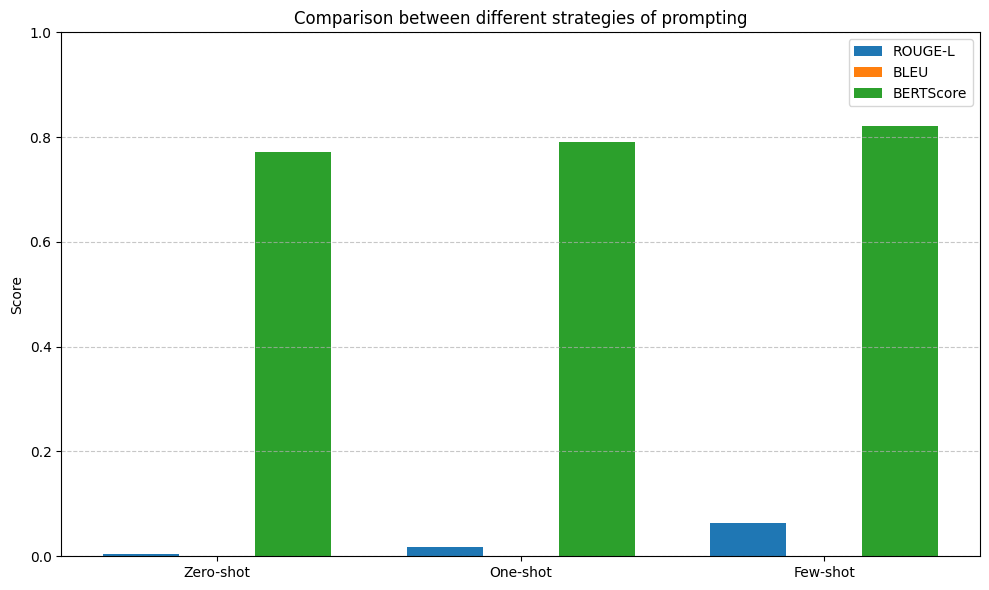

In [ ]:
# Collect evaluation scores for each prompting method
prompting_methods = ['Zero-shot', 'One-shot', 'Few-shot']

# ROUGE-L scores
rouge_scores_flan = [
    zero_shot_results_flan['rouge']['rougeL'],
    one_shot_results_flan['rouge']['rougeL'],
    few_shot_results_flan['rouge']['rougeL']
]

# BLEU scores
bleu_scores_flan = [
    zero_shot_results_flan['bleu']['bleu'],
    one_shot_results_flan['bleu']['bleu'],
    few_shot_results_flan['bleu']['bleu']
]

# BERTScore values
bertscore_scores_flan = [
    zero_shot_results_flan['bertscore'],
    one_shot_results_flan['bertscore'],
    few_shot_results_flan['bertscore']
]

# Configure bar chart
x = range(len(prompting_methods))
bar_width = 0.25


# Plot bars for each metric
plt.figure(figsize=(10, 6))
plt.bar([i - bar_width for i in x], rouge_scores_flan, width=bar_width, label='ROUGE-L')
plt.bar(x, bleu_scores_flan, width=bar_width, label='BLEU')
plt.bar([i + bar_width for i in x], bertscore_scores_flan, width=bar_width, label='BERTScore')

# Set labels and formatting
plt.xticks(x, prompting_methods)
plt.ylabel('Score')
plt.title('Comparison between different strategies of prompting')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


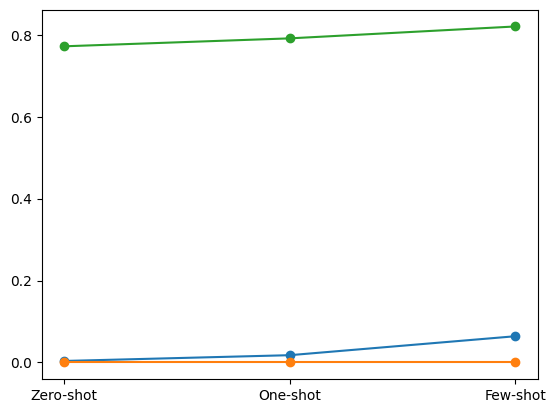

In [ ]:
# Line plot for FLAN scores across prompting strategies

# Plot ROUGE-L scores
plt.plot(prompting_methods, rouge_scores_flan, marker='o', label='ROUGE-L')

# Plot BLEU scores
plt.plot(prompting_methods, bleu_scores_flan, marker='o', label='BLEU')

# Plot BERTScore values
plt.plot(prompting_methods, bertscore_scores_flan, marker='o', label='BERTScore')

##Interactive Simulation

In [ ]:
model_flan = model_flan.to(device)

In [ ]:
def answer_question_flan(question, cot=""):
    # Build instruction-style prompt
    prompt = question.strip()
    if cot.strip():
        prompt = cot.strip() + "\n" + prompt

    # Tokenize the input
    inputs = tokenizer_flan(prompt, return_tensors="pt", max_length=512, truncation=True)
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Generate output from the model
    output_ids = model_flan.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=256,
        num_beams=4,
        early_stopping=True,
        do_sample=False
    )

    # Decode the output
    response = tokenizer_flan.decode(output_ids[0], skip_special_tokens=True).strip()
    return response

In [ ]:
# Run interactive loop
if __name__ == "__main__":
    print("Interactive Q&A with FLAN (type 'exit' to stop):")
    while True:
        question = input("Insert your question: ")
        if question.lower() == "exit":
            break
        cot = input("Insert your chain of thought (optional): ")
        answer = answer_question_flan(question, cot)
        print("\nAnswer:\n", answer)
        print("-" * 50)

Interactive Q&A with FLAN (type 'exit' to stop):
Insert your question: what are diabetes symptoms?
Insert your chain of thought (optional): 

Answer:
 Diabetic coma
--------------------------------------------------
Insert your question: An 8-year-old boy presents with 6 months of progressive fatigue, weight loss, decreased energy, loose stools, occasional abdominal pain and nausea, tanned skin, and bluish-black gums. Serum studies indicate hyponatremia, hyperkalemia, and hypoglycemia. Based on these symptoms and laboratory findings, what is the initial step in treatment that should be administered to this patient?
Insert your chain of thought (optional): 

Answer:
 Glucose tolerance test
--------------------------------------------------
Insert your question: exit


# **Comparing Phi-3-mini and Flan-T5**
The figure displays a side-by-side comparison of Phi-3-mini-4k-instruct and Flan-T5-large across three prompting strategies: Zero-shot, One-shot, and Few-shot. Each subplot represents a different evaluation metric — ROUGE-L, BLEU, and BERTScore — showing the performance scores for both models. Phi-3 generally outperforms Flan-T5, particularly in semantic similarity (BERTScore), while both models show relatively low performance on lexical metrics (ROUGE and BLEU) under minimal prompting.



In [ ]:
prompting_methods = ['Zero-shot', 'One-shot', 'Few-shot']

In [ ]:
# Define evaluation metrics for Phi-3
metrics_phi = {
    "ROUGE-L": [
        zero_shot_results_phi['rouge']['rougeL'],
        one_shot_results_phi['rouge']['rougeL'],
        few_shot_results_phi['rouge']['rougeL']
    ],
    "BLEU": [
        zero_shot_results_phi['bleu']['bleu'],
        one_shot_results_phi['bleu']['bleu'],
        few_shot_results_phi['bleu']['bleu']
    ],
    "BERTScore": [
        zero_shot_results_phi['bertscore'],
        one_shot_results_phi['bertscore'],
        few_shot_results_phi['bertscore']
    ]
}


In [ ]:
# Define evaluation metrics for Flan-T5
metrics_flan = {
    "ROUGE-L": [
        zero_shot_results_flan['rouge']['rougeL'],
        one_shot_results_flan['rouge']['rougeL'],
        few_shot_results_flan['rouge']['rougeL']
    ],
    "BLEU": [
        zero_shot_results_flan['bleu']['bleu'],
        one_shot_results_flan['bleu']['bleu'],
        few_shot_results_flan['bleu']['bleu']
    ],
    "BERTScore": [
        zero_shot_results_flan['bertscore'],
        one_shot_results_flan['bertscore'],
        few_shot_results_flan['bertscore']
    ]
}

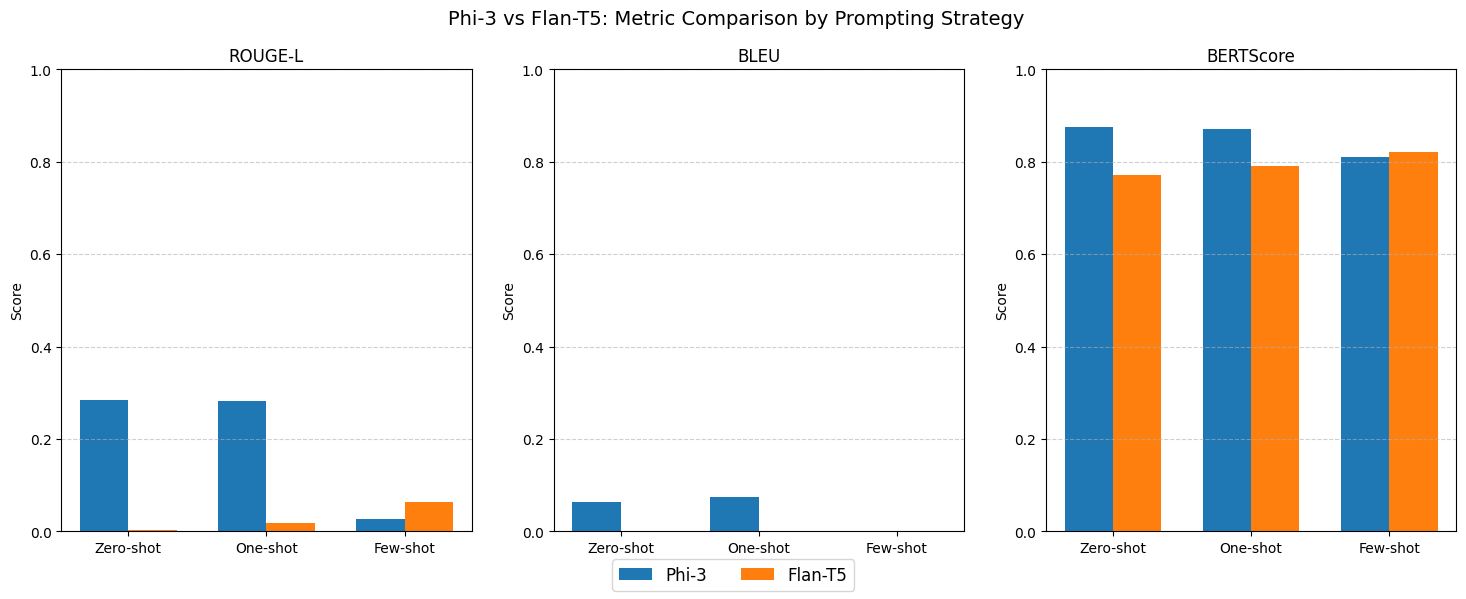

In [ ]:
# Set up subplot layout: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 riga, 3 colonne

bar_width = 0.35
x = range(len(prompting_methods)) # [0, 1, 2] for Zero, One, Few-shot

# Plot each metric in a separate subplot
for idx, metric in enumerate(["ROUGE-L", "BLEU", "BERTScore"]):
    phi_scores = metrics_phi[metric]
    flan_scores = metrics_flan[metric]

    # Side-by-side bar plots
    axs[idx].bar([i - bar_width/2 for i in x], phi_scores, width=bar_width, label='Phi-3')
    axs[idx].bar([i + bar_width/2 for i in x], flan_scores, width=bar_width, label='Flan-T5')

    # Formatting
    axs[idx].set_title(metric)
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(prompting_methods)
    axs[idx].set_ylim(0, 1)
    axs[idx].set_ylabel("Score")
    axs[idx].grid(axis="y", linestyle="--", alpha=0.6)

# Add global legend and title
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)
fig.suptitle("Phi-3 vs Flan-T5: Metric Comparison by Prompting Strategy", fontsize=14)

# Adjust layout to make room for legend and title
plt.tight_layout(rect=[1, 0.05, 1, 0.95])
plt.show()